In [ ]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
DATA_PATH = os.environ.get("data_path")
sys.path.insert(0, os.getenv('lib_path'))
sys.path.insert(0, os.getenv('root_path'))

In [1]:
from lib.notebook_imports import *
import itertools
import scipy.cluster.hierarchy as shc
import prince
from scipy import sparse
import plotly.graph_objects as go

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)

%load_ext autoreload
%autoreload 2

shap.initjs()

start_time = datetime.now()


The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.


# READ DATA

In [ ]:
data_900 = read_data(
    DATA_PATH, 
    merge_with_meds=True, 
    merge_with_patient_genes=True, 
    vcf=False,
    remove_outliers=True)

LGB_PARAMS_BASE, N_FOLDS, ALL_MODEL_SUFFIXES, BASE_COLS_1, BASE_COLS_2, ranking_cols = get_consts()

data_900_df = data_900.input_df.copy()

In [ ]:
data_2015_df = read_data_2015(DATA_PATH)

In [ ]:
genetic_data = read_vcf_files(
    DATA_PATH,
    DATA_PATH+"/vcf/",
)
genome_df, genome_012_cols, hetero_cols, homo_cols, has_alt_cols = prepare_genome_df(genetic_data)
print(f'before merge: {len(data_900_df)}')
data_900_df = data_900_df.merge(genome_df, left_on='__id__', right_on='patient_id', how='inner')
print(f'after merge:  {len(data_900_df)}')
chromosomes = [
    "chr11",
    "chr12",
    "chr14",
    "chr17",
    "chr19",
    "chr2",
    "chr5",
    "chr6",
    "chrX",
]
methods = ['GABRIEL', '4GAM', 'SPINE']
data_900_df, all_block_cols = read_haploview_data(
    DATA_PATH +"/poprawne_vcf_haplotypes/haplotypes/hmap", chromosomes, methods, data_900_df)
gabriel_cols = [col for col in all_block_cols if 'GABRIEL' in col and 'NONE' not in col]
fourgam_cols = [col for col in all_block_cols if '4GAM' in col and 'NONE' not in col]
spine_cols = [col for col in all_block_cols if 'SPINE' in col and 'NONE' not in col]
data_900_df.shape

In [7]:
len(data_900_df.__id__.unique())

430

In [6]:
gabriel_cols.__len__()+fourgam_cols.__len__()+spine_cols.__len__()

311

In [10]:
data_900_df['prev_proc-difference'] = data_900_df['prev_proc-day_0_mii']-data_900_df['prev_proc-cumulus_denuded']

In [8]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


# PREPARE COLUMN SETS

In [ ]:
%%time

GENE_COL_SETS = prepare_gene_column_sets(
    data_900,
    LGB_PARAMS_BASE,
    BASE_COLS_2,
    DATA_SERIES_900,
    ['l1', 'l2', 'log_l2', 'mape'],
    call=True
)


# Model referencyjny

In [97]:
REF_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco"
]
REF_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    REF_COLS,
    model_suffixes_filter=['h20'])
REF_RESULTS.print_errors(
    [REF_RESULTS],
    print_suffixes=['h20'],
    print_avg=True,
)


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][h20][900_cumulus_denuded]: count:516    avg:7.67   nan    (nan)    
MAE[ test_fold_avg][h20][900_cumulus_denuded]: count:516    avg:7.67   nan    (nan)    
MAPE[ test_fold_avg][h20][900_cumulus_denuded]: count:516    avg:7.67   nan    (nan)    
LIKELIHOOD[ test_fold_avg][h20][900_cumulus_denuded]: count:516    avg:7.67   0.82    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][h20][900_day_0_mii]:      count:516    avg:5.92   nan    (nan)    
MAE[ test_fold_avg][h20][900_day_0_mii]:       count:516    avg:5.92   nan    (nan)    
MAPE[ test_fold_avg][h20][900_day_0_mii]:      count:516    avg:5.92   nan    (nan)    
LIKELIHOOD[ test_fold_avg][h20][900_day_0_mii]: count:516    avg:5.92   0.82    (0.00)    
-----------------------------


Original records: 12892
Filtered records: 8574
Original records: 12892
Filtered records: 8574


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][l2][2015_cumulus_denuded]: count:8574   avg:9.14   4.54    (0.00)    
MAE[ test_fold_avg][l2][2015_cumulus_denuded]: count:8574   avg:9.14   3.38    (0.00)    
MAPE[ test_fold_avg][l2][2015_cumulus_denuded]: count:8574   avg:9.14   0.60    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][2015_cumulus_denuded]: count:8574   avg:9.14   7.25    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][2015_day_0_mii]:      count:8574   avg:6.96   3.80    (0.00)    
MAE[ test_fold_avg][l2][2015_day_0_mii]:       count:8574   avg:6.96   2.84    (0.00)    
MAPE[ test_fold_avg][l2][2015_day_0_mii]:      count:8574   avg:6.96   0.65    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][2015_day_0_mii]: count:8574   avg:6.96   4.63    (0.00)    
-----------------------------


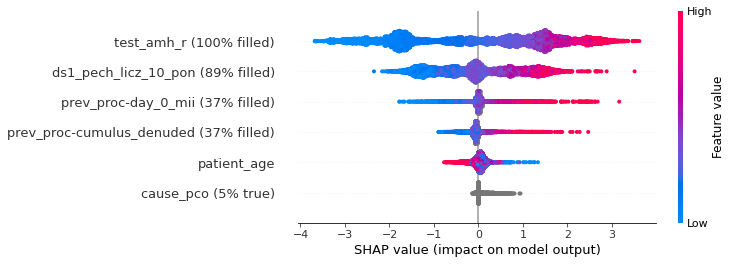

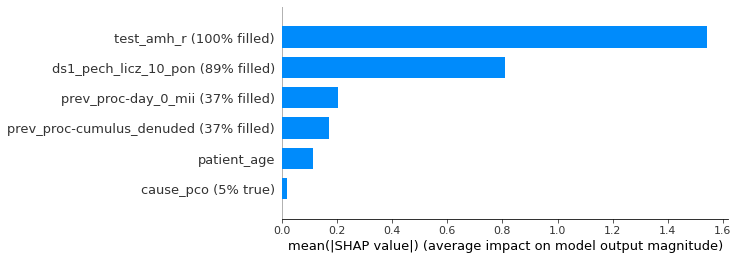

In [208]:
DATA_SERIES_2015 = {}
DATA_SERIES_2015['2015_cumulus_denuded'] = prepare_data_serie(data_2015_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_2015['2015_day_0_mii'] = prepare_data_serie(data_2015_df, 'day_0_mii', N_FOLDS)
REF_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco"
]
REF_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_2015,
    REF_COLS,
    model_suffixes_filter=['l2'])
REF_RESULTS.print_errors(
    [REF_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    REF_RESULTS,
    data_serie_name='2015_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
REF_RESULTS_df = REF_RESULTS.get_merged_test_dfs_from_folds('2015_day_0_mii').copy()
REF_RESULTS_df['error'] = REF_RESULTS_df['day_0_mii']-REF_RESULTS_df['prediction_l2']

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   4.46    (0.00)    
MAE[ test_fold_avg][l2][900_cumulus_denuded]:  count:516    avg:7.67   3.19    (0.00)    
MAPE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   0.76    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   5.52    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.53    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.58    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.71    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


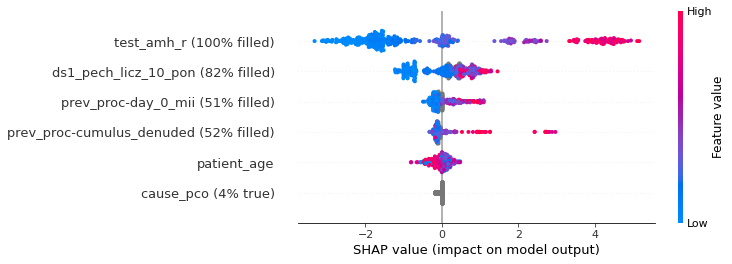

<Figure size 648x792 with 0 Axes>

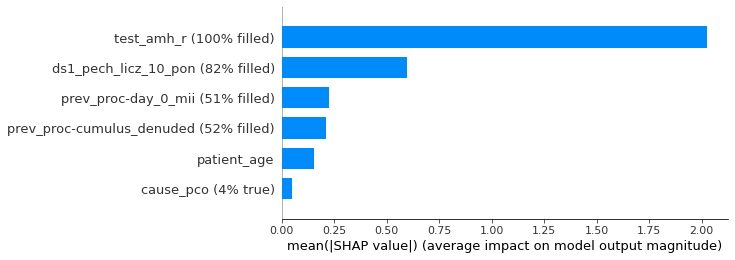

<Figure size 648x792 with 0 Axes>

In [54]:
REF_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco"
]
REF_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    REF_COLS,
    model_suffixes_filter=['l2'])
REF_RESULTS.print_errors(
    [REF_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    REF_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
REF_RESULTS_df = REF_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
REF_RESULTS_df['error'] = REF_RESULTS_df['day_0_mii']-REF_RESULTS_df['prediction_l2']

# Rarest columns

In [11]:
differences_df = get_differences_df(data_900_df,GENE_COL_SETS)

In [12]:
stim_cols_less_selected = rarest_variants_combinations(data_900_df,differences_df,LGB_PARAMS_BASE)
stim_cols_more_selected = rarest_variants_combinations(data_900_df,differences_df,LGB_PARAMS_BASE,less=False)
destim_cols_less_selected = rarest_variants_combinations(data_900_df,differences_df,LGB_PARAMS_BASE,stim=False)
destim_cols_more_selected = rarest_variants_combinations(data_900_df,differences_df,LGB_PARAMS_BASE,stim=False,less = False)

Boolean Series key will be reindexed to match DataFrame index.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Boolean Series key w

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Boolean Series key w

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Boolean Series key w

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


In [22]:
data_900_df['stim_cols_less_selected'] = data_900_df[stim_cols_less_selected].sum(axis = 1)
data_900_df['destim_cols_less_selected'] = data_900_df[destim_cols_less_selected].sum(axis = 1)
data_900_df['destim_cols_more_selected'] = data_900_df[destim_cols_more_selected].sum(axis = 1)
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   4.32    (0.00)    
MAE[ test_fold_avg][l2][900_cumulus_denuded]:  count:516    avg:7.67   3.09    (0.00)    
MAPE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   0.73    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   5.52    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.40    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.49    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.68    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


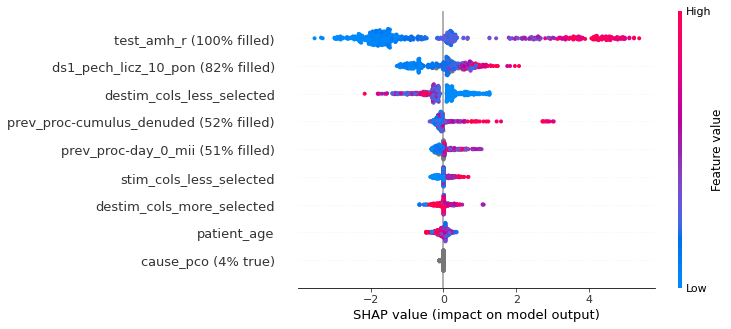

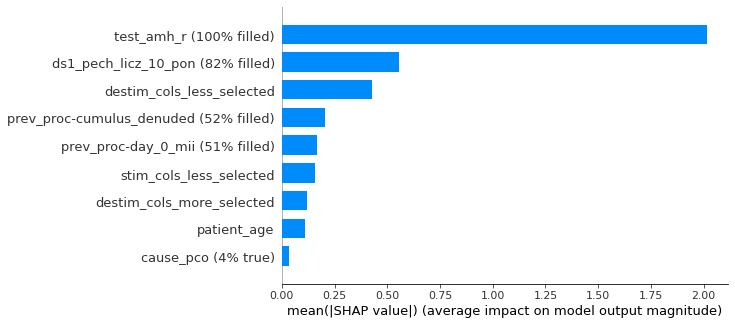

In [23]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",            
    'stim_cols_less_selected',
    'destim_cols_less_selected',
    'destim_cols_more_selected'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']

<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

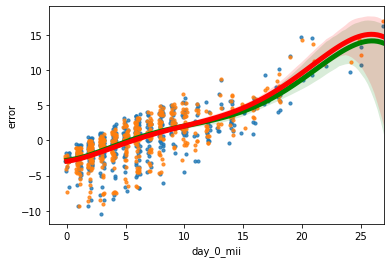

In [20]:
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 95,
    scatter_kws={"s": 10},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.2,
    ci = 95,
    scatter_kws={"s": 10},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

In [19]:
stim_cols_less_selected=['SOX9_17_72123461_G_-',
 'ESR2_14_64280216_-_A',
 'SOX9_17_72124489_G_TGT',
 'LHCGR_2_48755729_C_A',
 'ESR1_6_151808173_G_-',
 'LHCGR_2_48694236_T_C',
 'ESR2_14_64226699_-_TTTTTT',
 'ESR2_14_64233327_T_C',
 'PRL_6_22292472_A_G',
 'PRLR_5_35230396_G_A',
 'PRLR_5_35230278_G_C',
 'OTHER_6_22287169_A_T']

In [15]:
stim_cols_less_selected

['SOX9_17_72123461_G_-',
 'ESR2_14_64280216_-_A',
 'SOX9_17_72124489_G_TGT',
 'LHCGR_2_48755729_C_A',
 'ESR1_6_151808173_G_-',
 'LHCGR_2_48694236_T_C',
 'ESR2_14_64226699_-_TTTTTT',
 'ESR2_14_64233327_T_C',
 'PRL_6_22292472_A_G',
 'PRLR_5_35230396_G_A',
 'PRLR_5_35230278_G_C',
 'OTHER_6_22287169_A_T']

In [20]:
destim_cols_less_selected=['PRLR_5_35072610_T_G',
 'AR_X_67722634_A_G',
 'FSHR_2_48989016_C_T',
 'ESR2_14_64235053_A_G',
 'SOX9_17_72124635_A_G',
 'PRLR_5_35055852_GC_TT',
 'PRLR_5_35064922_C_G',
 'ESR1_6_151808453_C_T',
 'ESR2_14_64228031_T_G',
 'PRLR_5_35069864_G_A',
 'ESR1_6_152101993_T_C',
 'PRLR_5_35059611_C_A',
 'OTHER_19_2249216_G_A',
 'ESR1_6_152102770_T_A',
 'SOX9_17_72126087_TTTTTTT_-',
 'ESR2_14_64303383_TTTTTTTTTTT_-',
 'ESR2_14_64227364_T_C',
 'PRLR_5_35230050_T_A',
 'ESR2_14_64280271_T_C',
 'AR_X_67722783_G_A',
 'ESR1_6_152011609_G_A',
 'SOX3_X_140503266_GA_AG']

In [16]:
destim_cols_less_selected

['PRLR_5_35072610_T_G',
 'AR_X_67722634_A_G',
 'FSHR_2_48989016_C_T',
 'ESR2_14_64235053_A_G',
 'SOX9_17_72124635_A_G',
 'PRLR_5_35055852_GC_TT',
 'PRLR_5_35064922_C_G',
 'ESR1_6_151808453_C_T',
 'ESR2_14_64228031_T_G',
 'PRLR_5_35069864_G_A',
 'ESR1_6_152101993_T_C',
 'PRLR_5_35059611_C_A',
 'OTHER_19_2249216_G_A',
 'ESR1_6_152102770_T_A',
 'SOX9_17_72126087_TTTTTTT_-',
 'ESR2_14_64303383_TTTTTTTTTTT_-',
 'ESR2_14_64227364_T_C',
 'PRLR_5_35230050_T_A',
 'ESR2_14_64280271_T_C',
 'AR_X_67722783_G_A',
 'ESR1_6_152011609_G_A',
 'SOX3_X_140503266_GA_AG']

In [21]:
destim_cols_more_selected=['ESR2_14_64226599_T_C',
 'AR_X_67721755_T_G',
 'AMH_19_2250529_G_A',
 'FSHR_2_48989145_C_T',
 'ESR1_6_152101200_C_T',
 'AR_X_67730181_AAG_-',
 'AR_X_67725898_T_C',
 'AR_X_67730263_C_T',
 'ESR1_6_151880740_T_C',
 'OTHER_19_2249113_G_A',
 'ESR1_6_152103343_A_G']

In [17]:
destim_cols_more_selected

['ESR2_14_64226599_T_C',
 'AR_X_67721755_T_G',
 'AMH_19_2250529_G_A',
 'FSHR_2_48989145_C_T',
 'ESR1_6_152101200_C_T',
 'AR_X_67730181_AAG_-',
 'AR_X_67725898_T_C',
 'AR_X_67730263_C_T',
 'ESR1_6_151880740_T_C',
 'OTHER_19_2249113_G_A',
 'ESR1_6_152103343_A_G']

# GENE COLUMNS BASED ON SOM, CORRESPONDANT ANALYSIS AND ECDF plots

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   4.41    (0.00)    
MAE[ test_fold_avg][l2][900_cumulus_denuded]:  count:516    avg:7.67   3.20    (0.00)    
MAPE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   0.78    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   5.52    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.46    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.57    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.70    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


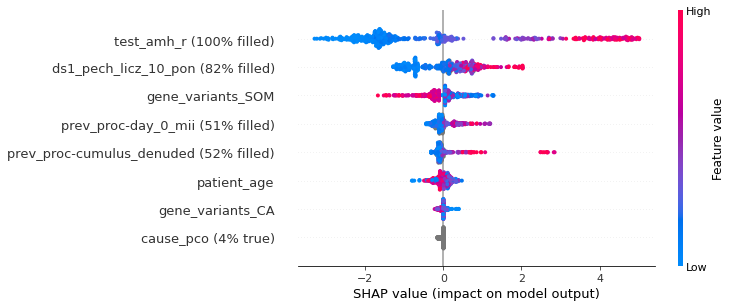

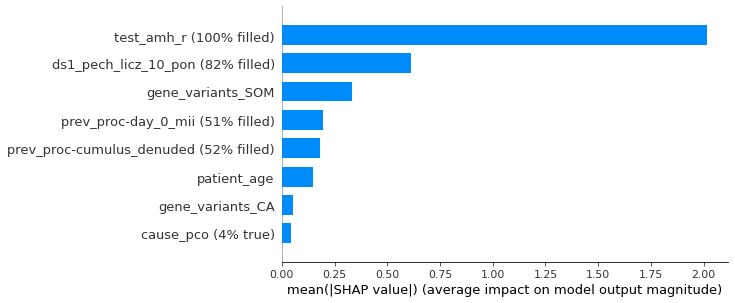

In [24]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
    #'gene_variants_ecdf',
    'gene_variants_SOM',
    #'gene_variants_MIM_stimulate',
    #'gene_variants_MIM',
    'gene_variants_CA'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']

<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

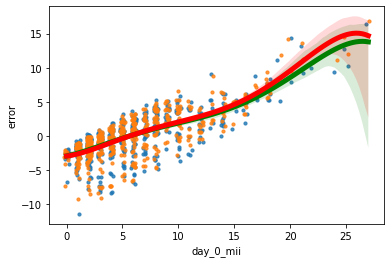

In [22]:
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 95,
    scatter_kws={"s": 10},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.2,
    ci = 95,
    scatter_kws={"s": 10},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

# ADD COLUMNS BASED ON STATISTICAL TESTS

In [35]:
gene_columns_test,mwu_less,mwu_greater,ks_less,ks_greater,tests_less,tests_greater = get_statistical_significance(data_900_df,GENE_COL_SETS)

In [185]:
from scipy import stats

In [193]:
x = stats.norm.rvs(loc=0, size=100)
y = stats.norm.rvs(loc=1., size=100)
stats.kstest(x, y, alternative='less')

KstestResult(statistic=0.0, pvalue=1.0)

In [182]:
pd.options.display.float_format = '{:,.2f}'.format
gene_columns_test.loc[np.isin(gene_columns_test.column_name,tests_less)]

column_name  mwu_less_stat  mwu_less_p  mwu_greater_stat  \
43      AR_X_67544940_C_A       8,940.50        0.00          8,940.50   
51      AR_X_67545395_C_-       6,226.50        0.00          6,226.50   
272  ESR2_14_64280216_-_A      18,116.50        0.00         18,116.50   
442  LHCGR_2_48729336_C_T      72,783.50        0.00         72,783.50   
446  LHCGR_2_48755729_C_A      42,881.50        0.00         42,881.50   
486  OTHER_6_22287169_A_T       9,341.50        0.02          9,341.50   
585   PRLR_5_35229973_C_A       9,066.00        0.00          9,066.00   
586   PRLR_5_35230018_C_A       9,604.50        0.01          9,604.50   
589   PRLR_5_35230124_G_A       9,604.50        0.01          9,604.50   
592   PRLR_5_35230200_G_C       9,604.50        0.01          9,604.50   
595   PRLR_5_35230396_G_A      14,720.50        0.01         14,720.50   
630  SOX9_17_72123628_C_-      13,194.00        0.00         13,194.00   

     mwu_greater_p  ks_less_stat  ks_less_p  ks_greater_stat  ks_greater_p  \
43            1.00          0.46       0.00             0.00          1.00   
51            1.00          0.90       0.00             0.00          1.00   
272           1.00          0.21       0.02             0.00          1.00   
442           1.00          0.12       0.01             0.01          0.97   
446           1.00          0.14       0.01             0.00          1.00   
486           0.98          0.32       0.01             0.04          0.90   
585           1.00          0.29       0.03             0.01          0.99   
586           0.99          0.29       0.03             0.01          0.99   
589           0.99          0.29       0.03             0.01          0.99   
592           0.99          0.29       0.03             0.01          0.99   
595           0.99          0.23       0.02             0.02          0.97   
630           1.00          0.47       0.00             0.02          0.98   

     count  
43   23.00  
51   21.00  
272  56.00  
442 408.00  
446 153.00  
486  28.00  
585  31.00  
586  33.00  
589  33.00  
592  33.00  
595  48.00  
630  48.00

In [47]:
data_900_df.groupby('LHCGR_2_48729336_C_T').mean()['day_0_mii']

LHCGR_2_48729336_C_T
False    6.218362
True     7.771160
Name: day_0_mii, dtype: float64

In [48]:
data_900_df.groupby('AMH_19_2250529_G_A').mean()['day_0_mii']

AMH_19_2250529_G_A
False    8.880435
True     6.228625
Name: day_0_mii, dtype: float64

In [183]:
gene_columns_test.loc[np.isin(gene_columns_test.column_name,tests_greater)]

column_name  mwu_less_stat  mwu_less_p  \
27                          AMH_19_2250529_G_A      39,418.50        1.00   
70                           AR_X_67721755_T_G      24,089.50        1.00   
73                           AR_X_67722634_A_G       6,156.50        1.00   
90                           AR_X_67725898_T_C      15,678.50        1.00   
111                        AR_X_67730181_AAG_-      40,474.00        1.00   
168                       ESR1_6_151880740_T_C      51,220.50        1.00   
195                       ESR1_6_152098960_G_A      45,861.50        1.00   
211                       ESR1_6_152101200_C_T      36,921.50        1.00   
216                       ESR1_6_152101993_T_C      13,812.50        0.98   
226                       ESR1_6_152103343_A_G      40,263.50        0.99   
230                       ESR2_14_64226599_T_C      19,798.50        1.00   
245                       ESR2_14_64227364_T_C      14,554.00        1.00   
252                       ESR2_14_64228031_T_G      11,075.00        1.00   
320                       FSHB_11_30234748_T_G      11,601.50        1.00   
345                        FSHR_2_48989145_C_T      37,402.00        1.00   
433                       LHCGR_2_48725562_C_G      24,976.50        1.00   
476                      OTHER_5_132861019_C_T      33,071.50        0.97   
477                      OTHER_5_132861108_C_T      32,802.00        0.97   
554                        PRLR_5_35064922_C_G      12,007.00        1.00   
599                         PRL_6_22292225_T_C      35,635.00        0.99   
651                 SOX9_17_72126087_TTTTTTT_-      15,003.00        1.00   
659  FSHR_2_49154446_C_T___5 Prime UTR Variant      45,611.00        1.00   

     mwu_greater_stat  mwu_greater_p  ks_less_stat  ks_less_p  \
27          39,418.50           0.00          0.00       1.00   
70          24,089.50           0.00          0.00       1.00   
73           6,156.50           0.00          0.00       1.00   
90          15,678.50           0.00          0.01       0.99   
111         40,474.00           0.00          0.00       1.00   
168         51,220.50           0.00          0.00       1.00   
195         45,861.50           0.00          0.00       1.00   
211         36,921.50           0.00          0.00       1.00   
216         13,812.50           0.02          0.00       0.99   
226         40,263.50           0.01          0.00       1.00   
230         19,798.50           0.00          0.01       0.98   
245         14,554.00           0.00          0.01       0.99   
252         11,075.00           0.00          0.00       1.00   
320         11,601.50           0.00          0.00       1.00   
345         37,402.00           0.00          0.00       1.00   
433         24,976.50           0.00          0.00       1.00   
476         33,071.50           0.03          0.02       0.92   
477         32,802.00           0.03          0.02       0.91   
554         12,007.00           0.00          0.00       1.00   
599         35,635.00           0.01          0.00       1.00   
651         15,003.00           0.00          0.01       0.98   
659         45,611.00           0.00          0.00       1.00   

     ks_greater_stat  ks_greater_p  count  
27              0.17          0.00 225.00  
70              0.20          0.00 111.00  
73              0.30          0.01  31.00  
90              0.18          0.02  66.00  
111             0.15          0.00 190.00  
168             0.12          0.01 328.00  
195             0.12          0.02 262.00  
211             0.15          0.00 176.00  
216             0.19          0.03  54.00  
226             0.11          0.04 195.00  
230             0.23          0.00  87.00  
245             0.25          0.00  95.00  
252             0.26          0.00  71.00  
320             0.20          0.03  56.00  
345             0.14          0.00 184.00  
433             0.23          0.00 112.00  
476             0.1

In [16]:
for i in [mwu_less,mwu_greater,ks_less,ks_greater,tests_less,tests_greater]:
    print(i)

['AR_X_67544940_C_A', 'AR_X_67545395_C_-', 'ESR1_6_151808173_G_-', 'ESR1_6_152061247_G_A', 'ESR1_6_152098584_C_T', 'ESR2_14_64233327_T_C', 'ESR2_14_64280216_-_A', 'LHCGR_2_48729336_C_T', 'LHCGR_2_48755729_C_A', 'OTHER_6_22287169_A_T', 'PRLR_5_35060217_C_T', 'PRLR_5_35229973_C_A', 'PRLR_5_35230018_C_A', 'PRLR_5_35230124_G_A', 'PRLR_5_35230200_G_C', 'PRLR_5_35230278_G_C', 'PRLR_5_35230396_G_A', 'PRL_6_22292324_G_A', 'PRL_6_22292472_A_G', 'SOX9_17_72123628_C_-']
['AMHR2_12_53430960_A_G', 'AMH_19_2250470_G_A', 'AMH_19_2250529_G_A', 'AR_X_67721755_T_G', 'AR_X_67722634_A_G', 'AR_X_67722783_G_A', 'AR_X_67725898_T_C', 'AR_X_67730181_AAG_-', 'AR_X_67730263_C_T', 'ESR1_6_151808453_C_T', 'ESR1_6_151842200_T_-', 'ESR1_6_151880740_T_C', 'ESR1_6_151880872_T_C', 'ESR1_6_152011897_A_G', 'ESR1_6_152061176_G_T', 'ESR1_6_152061190_A_G', 'ESR1_6_152061285_A_G', 'ESR1_6_152098960_G_A', 'ESR1_6_152101200_C_T', 'ESR1_6_152101993_T_C', 'ESR1_6_152102770_T_A', 'ESR1_6_152103343_A_G', 'ESR2_14_64226599_T_C', 'E

In [17]:
data_900_df['mwu_less'] = data_900_df[mwu_less].sum(axis = 1)
data_900_df['mwu_greater'] = data_900_df[mwu_greater].sum(axis = 1)
data_900_df['ks_less'] = data_900_df[ks_less].sum(axis = 1)
data_900_df['ks_greater'] = data_900_df[ks_greater].sum(axis = 1)
data_900_df['tests_less'] = data_900_df[tests_less].sum(axis = 1)
data_900_df['tests_greater'] = data_900_df[tests_greater].sum(axis = 1)

DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   4.46    (0.00)    
MAE[ test_fold_avg][l2][900_cumulus_denuded]:  count:516    avg:7.67   3.20    (0.00)    
MAPE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   0.77    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   5.52    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.49    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.53    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.70    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


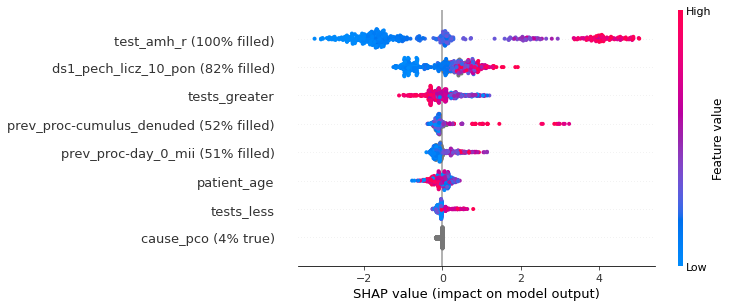

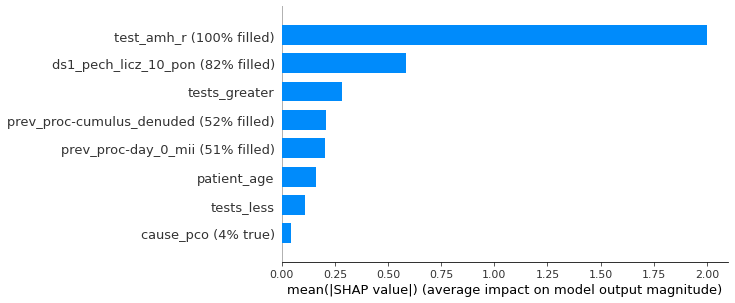

In [18]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",            
    'ks_less',
    'ks_greater'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
-
RMSE[ test_fold_av

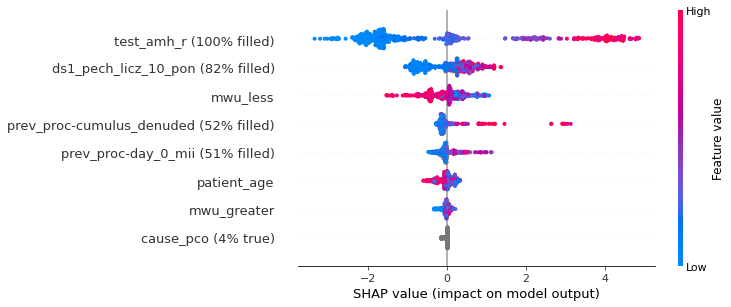

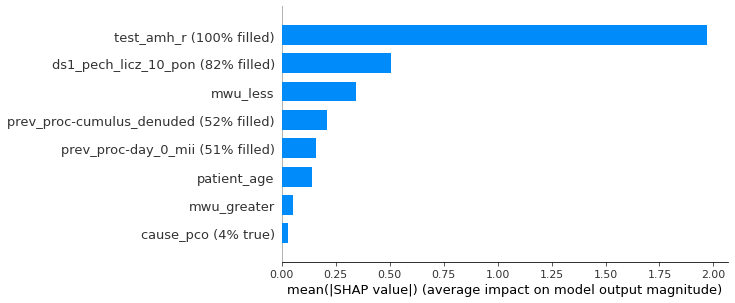

In [26]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",            
    'mwu_less',
    'mwu_greater'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']

<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

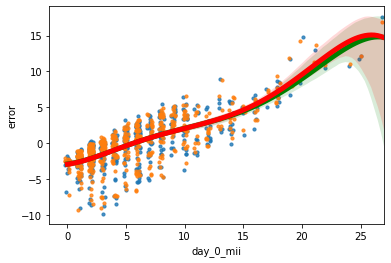

In [27]:
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 95,
    scatter_kws={"s": 10},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.2,
    ci = 95,
    scatter_kws={"s": 10},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516
-
RMSE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   4.46    (0.00)    
MAE[ test_fold_avg][l2][900_cumulus_denuded]:  count:516    avg:7.67   3.15    (0.00)    
MAPE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   0.74    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   5.52    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.53    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.58    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.70    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


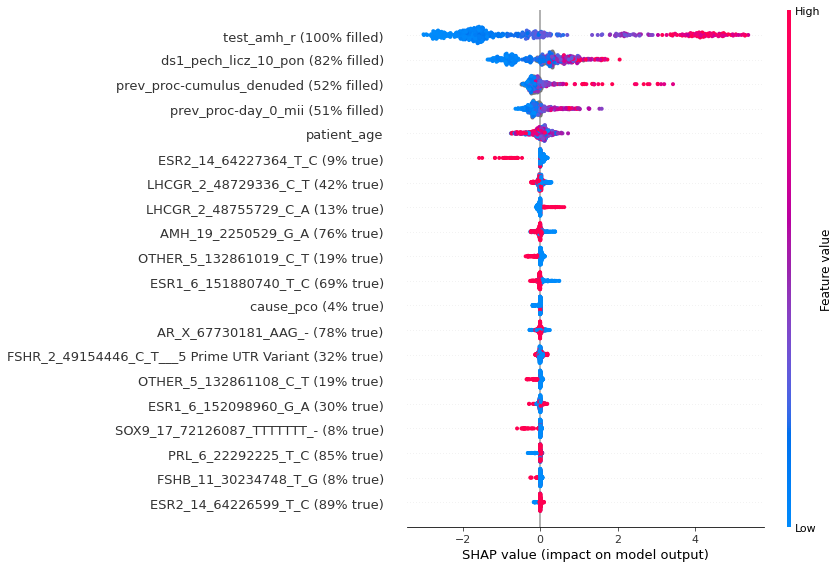

<Figure size 648x792 with 0 Axes>

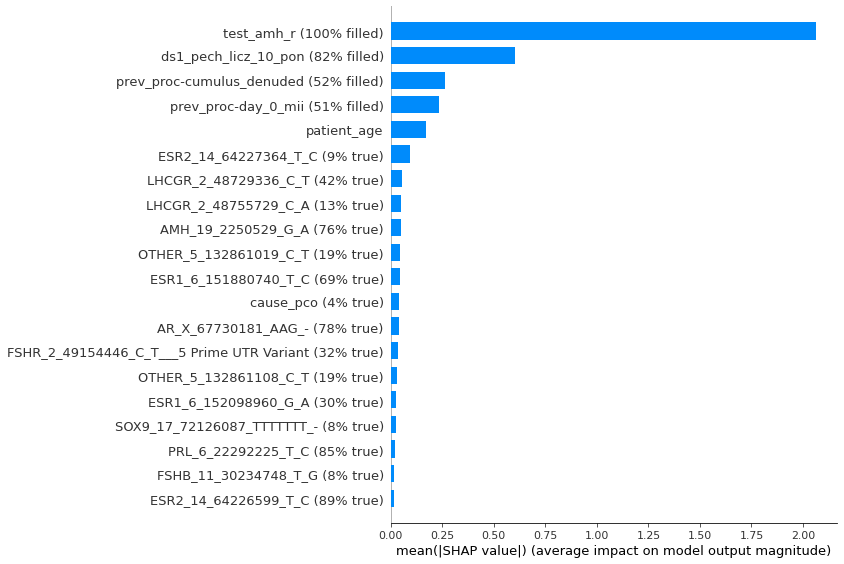

<Figure size 648x792 with 0 Axes>

In [195]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco"
]
GENE_ADD_COLS = GENE_ADD_COLS + tests_greater + tests_less
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']

# Haploview

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
-
RMSE[ test_fold_av

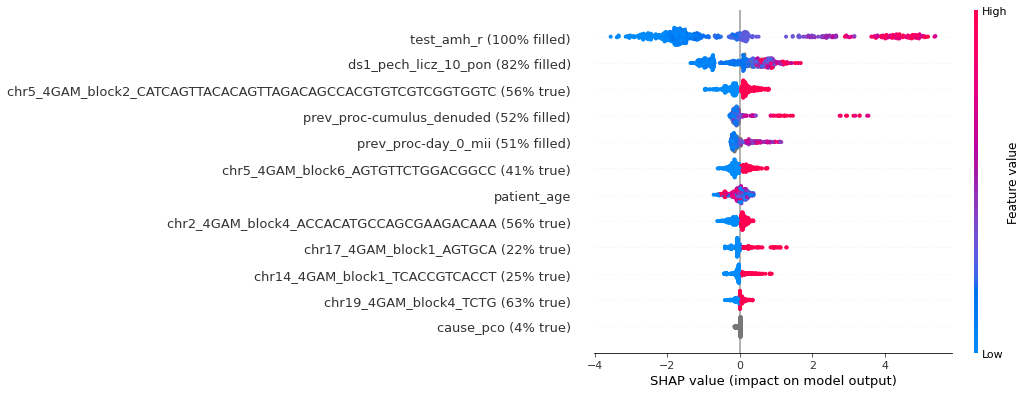

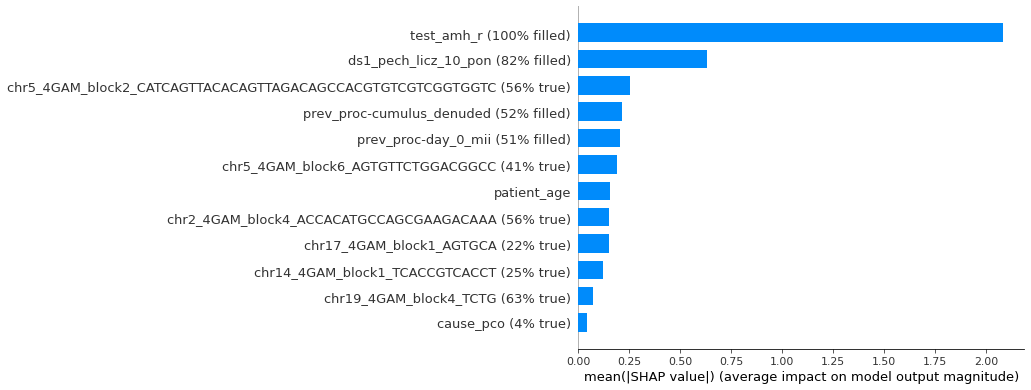

In [28]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
    "chr14_4GAM_block1_TCACCGTCACCT",
    "chr17_4GAM_block1_AGTGCA", 
    "chr19_4GAM_block4_TCTG", 
    "chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA",      
    "chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC", 
    "chr5_4GAM_block6_AGTGTTCTGGACGGCC"
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']


<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

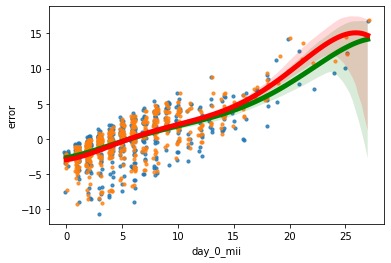

In [29]:
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 95,
    scatter_kws={"s": 10},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.2,
    ci = 95,
    scatter_kws={"s": 10},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

# Combinations of methods

In [25]:
genes_calculated_columns = [
    #'gene_variants_ecdf',
    'gene_variants_SOM',
    #'gene_variants_MIM_stimulate',
    #'gene_variants_MIM',
    'gene_variants_CA',
    #'stim_cols_less_selected',
    #'destim_cols_less_selected',
    #'ks_less',
    #'ks_greater',            
    #'mwu_less',
    #'mwu_greater',
    #"chr14_4GAM_block1_TCACCGTCACCT",
    'tests_less',
    'tests_greater',
    "chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA",
    "chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC",
    "chr5_4GAM_block6_AGTGTTCTGGACGGCC"]

In [26]:
import itertools

def all_combinations(any_list):
    return itertools.chain.from_iterable(
        itertools.combinations(any_list, i + 1)
        for i in range(len(any_list)))

In [27]:
ETA_900 = 0.5

0it [00:00, ?it/s]

# Number of column combinations: 127
# ETA: 0:04:14


127it [03:21,  1.59s/it]

model: l2
sorted_by: RMSE


index         0
0  RMSE_900_cumulus_denuded -0.157819
1        RMSE_900_day_0_mii -0.230852

RMSE_900_cumulus_denuded


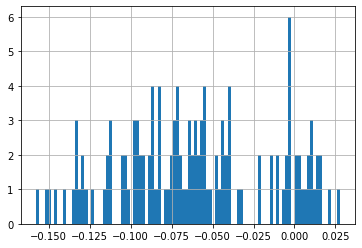

RMSE_900_day_0_mii


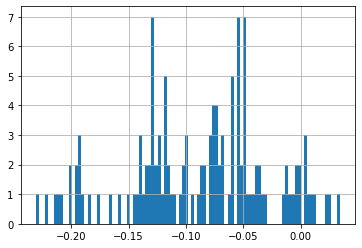

In [28]:
results_combinations = train_generated_cols(
    all_combinations(genes_calculated_columns),
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    BASE_COLS_2, REF_RESULTS,
    'l2', 'RMSE',
    10, ETA_900)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   4.30    (0.00)    
MAE[ test_fold_avg][l2][900_cumulus_denuded]:  count:516    avg:7.67   3.12    (0.00)    
MAPE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   0.75    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   5.52    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.32    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.48    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.68    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


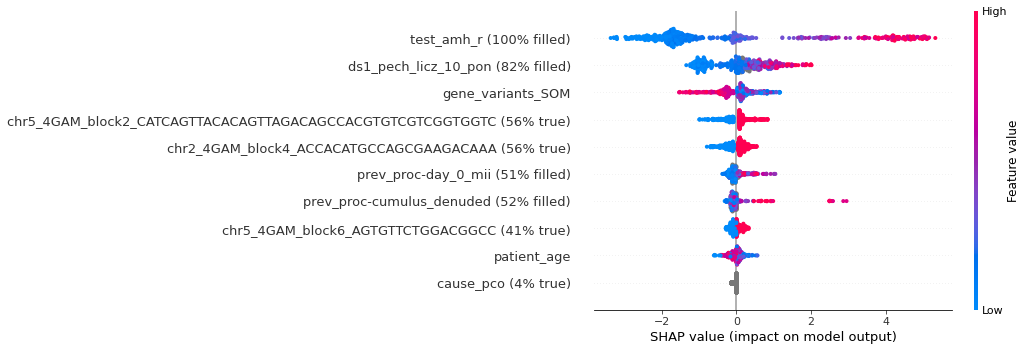

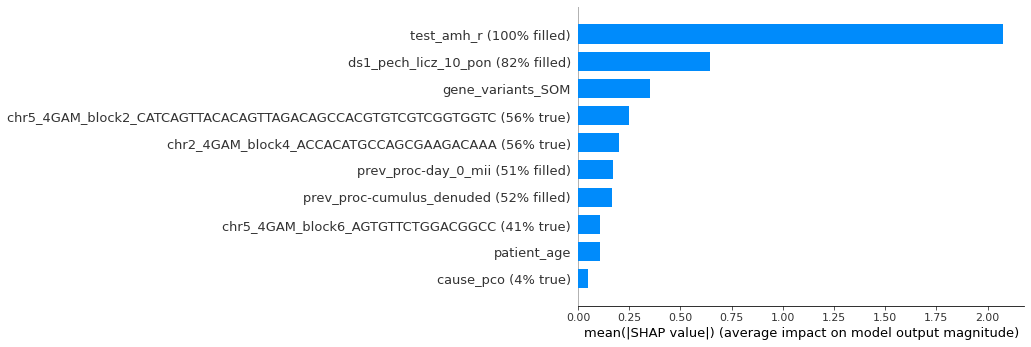

In [34]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",
   "gene_variants_SOM", "chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA", "chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC", "chr5_4GAM_block6_AGTGTTCTGGACGGCC"
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']

In [35]:
np.median(abs(GENE_RESULTS_df['error']))

1.942600286670992

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   4.46    (0.00)    
MAE[ test_fold_avg][l2][900_cumulus_denuded]:  count:516    avg:7.67   3.19    (0.00)    
MAPE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   0.76    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   5.52    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.53    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.58    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.71    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


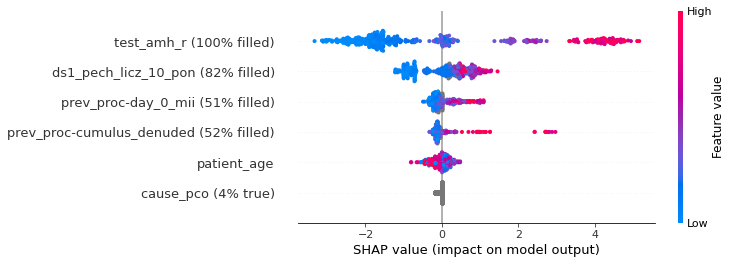

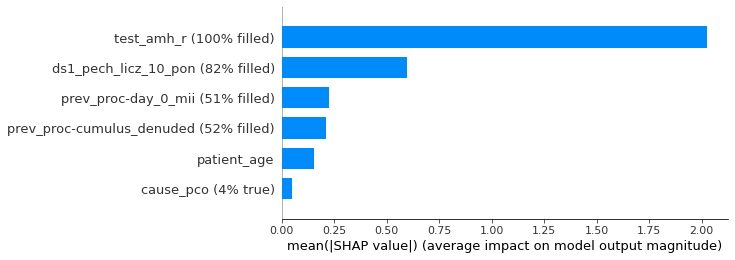

In [36]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco"
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']

In [37]:
np.median(abs(GENE_RESULTS_df['error']))

1.9916960797117425

<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

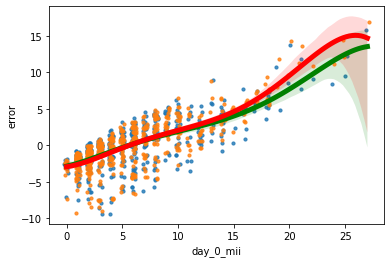

In [49]:
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 95,
    scatter_kws={"s": 10},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.2,
    ci = 95,
    scatter_kws={"s": 10},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

In [50]:
for i in [0.1,0.5,1,1.5,2]:
    print('Średni błąd dla pacjentek, u których zmiany genetyczne wpływają na predykcję o >{} MII'.format(i))
    biggest_genes_impact = GENE_RESULTS_df.iloc[np.where(abs(shap_vals[:,6:]).sum(axis = 1)>i)[0]].index
    print("Błąd z uwzględnieniem wariantów: {}".format(GENE_RESULTS_df.loc[biggest_genes_impact,'error'].abs().mean()))
    print("Błąd bez uwzględnienia wariantów: {}".format(REF_RESULTS_df.loc[biggest_genes_impact,'error'].abs().mean()))
    print("------------------------------------------")

Średni błąd dla pacjentek, u których zmiany genetyczne wpływają na predykcję o >0.1 MII
Błąd z uwzględnieniem wariantów: 2.4846720701838643
Błąd bez uwzględnienia wariantów: 2.580544037895747
------------------------------------------
Średni błąd dla pacjentek, u których zmiany genetyczne wpływają na predykcję o >0.5 MII
Błąd z uwzględnieniem wariantów: 2.715163697975649
Błąd bez uwzględnienia wariantów: 2.8503203828005765
------------------------------------------
Średni błąd dla pacjentek, u których zmiany genetyczne wpływają na predykcję o >1 MII
Błąd z uwzględnieniem wariantów: 3.851507490859874
Błąd bez uwzględnienia wariantów: 4.086443190263306
------------------------------------------
Średni błąd dla pacjentek, u których zmiany genetyczne wpływają na predykcję o >1.5 MII
Błąd z uwzględnieniem wariantów: 3.9820901685796026
Błąd bez uwzględnienia wariantów: 4.365011029292985
------------------------------------------
Średni błąd dla pacjentek, u których zmiany genetyczne wpływają

3.9820901685796026


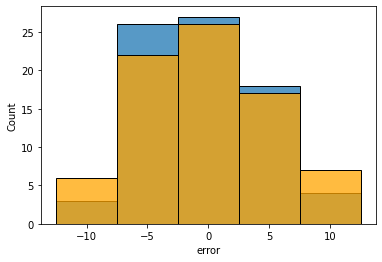

In [53]:
biggest_genes_impact = GENE_RESULTS_df.iloc[np.where(abs(shap_vals[:,6:]).sum(axis = 1)>1.5)[0]].index
sns.histplot(GENE_RESULTS_df.loc[biggest_genes_impact],x='error',bins=5,binrange=(-12.5,12.5))
sns.histplot(REF_RESULTS_df.loc[biggest_genes_impact],x='error',color='orange',bins = 5,binrange=(-12.5,12.5))
print(GENE_RESULTS_df.loc[biggest_genes_impact,'error'].abs().mean())

In [52]:
GENE_RESULTS_df.loc[
    (GENE_RESULTS_df['day_0_mii']<5)&
    (GENE_RESULTS_df['error']<-5)].loc[:,[
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",
    "gene_variants_ecdf",
    "gene_variants_MIM_stimulate", 
    "gene_variants_MIM", 
    "stim_cols_less_selected", 
    "mwu_less",
    "day_0_mii",
    "prediction_l2",
    "error"
]]

test_amh_r  ds1_pech_licz_10_pon  patient_age  prev_proc-cumulus_denuded  \
482       10.43                  27.0           36                        6.0   
656        2.27                   9.0           41                        9.0   
120       13.58                  30.0           31                        NaN   
253       12.42                  30.0           34                        NaN   
292        2.38                  19.0           25                       10.0   
404        3.74                   NaN           36                        7.0   
485        9.95                   NaN           36                       14.0   
565        6.32                  25.0           37                        NaN   
670        3.84                   NaN           39                        NaN   
671        3.84                  14.0           39                        7.0   
10         9.44                   NaN           36                        NaN   
280       12.65                  10.0           37                       15.0   
512       11.96                  47.0           28                        NaN   
113        4.89                  17.0           35                        NaN   
249        9.22                  40.0           28                        NaN   
334       11.57                  34.0           31                        NaN   
433        3.62                  20.0           29                        NaN   
573        8.14                  40.0           38                       14.0   
738        7.59                   NaN           31                        NaN   

     prev_proc-day_0_mii cause_pco  gene_variants_ecdf  \
482                  5.0     False                   1   
656                  6.0     False                   2   
120                  NaN     False                   2   
253                  NaN     False                   1   
292                  8.0     False                   2   
404                  6.0     False                   1   
485                 14.0     False                   0   
565                  NaN     False                   1   
670                  NaN     False                   1   
671                  3.0     False                   1   
10                   NaN     False                   2   
280                 10.0     False                   0   
512                  NaN      True                   1   
113                  NaN     False                   1   
249                  NaN     False                   1   
334                  NaN     False                   3   
433                  NaN     False                   1   
573                 12.0     False                   1   
738                  NaN     False                   0   

     gene_variants_MIM_stimulate  gene_variants_MIM  stim_cols_less_selected  \
482                            0                  1                        0   
656                            0                  1                        0   
120                            1                  2                        1   
253                            0                  1                        0   
292                            1                  1                        0   
404                            1                  0                        0   
485                            0                  1                        1   
565                            0                  1                        0   
670                            1                  2                        0   
671                            1                  2                        0   
10                             1                  0                        0   
280                            0                  1                        1   
512                            0                  0                        0   
113                            1                  0                        3   
249                    

# Statistical tests for differences in MII distribution for gene varians

In [79]:
from scipy.stats import kruskal,mannwhitneyu,kstest

In [86]:
data_900_df_mii = data_900_df.loc[pd.notna(data_900_df['mii_group'])].copy()
data_900_df_mii.reset_index(drop = True,inplace = True)

In [105]:
gene_column_list = GENE_COL_SETS.ALL_GENES_COLS_900
gene_columns_test = []
for gene_column in gene_column_list:
    if len(data_900_df_mii[gene_column].unique())>1:
        mwu_less = mannwhitneyu(data_900_df_mii.loc[data_900_df_mii[gene_column]==True,'day_0_mii'],
        data_900_df_mii.loc[data_900_df_mii[gene_column]==False,'day_0_mii'],
        alternative = 'less')
        mwu_greater = mannwhitneyu(data_900_df_mii.loc[data_900_df_mii[gene_column]==True,'day_0_mii'],
        data_900_df_mii.loc[data_900_df_mii[gene_column]==False,'day_0_mii'],
        alternative = 'greater')
        ks_less = kstest(data_900_df_mii.loc[data_900_df_mii[gene_column]==True,'day_0_mii'],
        data_900_df_mii.loc[data_900_df_mii[gene_column]==False,'day_0_mii'],
        alternative = 'less')
        ks_greater = kstest(data_900_df_mii.loc[data_900_df_mii[gene_column]==True,'day_0_mii'],
        data_900_df_mii.loc[data_900_df_mii[gene_column]==False,'day_0_mii'],
        alternative = 'greater')
        gene_columns_test.append([
            gene_column,
            mwu_less[0],
            mwu_less[1],
            mwu_greater[0],
            mwu_greater[1],
            ks_less[0],
            ks_less[1],
            ks_greater[0],
            ks_greater[1],
            data_900_df.groupby(gene_column)[gene_column].count().min()
            ])
    else:
        gene_columns_test.append([gene_column,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
gene_columns_test = pd.DataFrame(gene_columns_test, columns = [
    'column_name',
    'mwu_less_stat',
    'mwu_less_p',
    'mwu_greater_stat',
    'mwu_greater_p',
    'ks_less_stat',
    'ks_less_p',
    'ks_greater_stat',
    'ks_greater_p',
    'count'])

In [106]:
gene_columns_test.loc[(gene_columns_test['ks_less_p']<0.05)&
(gene_columns_test['count']>20),'column_name'].to_list()

['AR_X_67544940_C_A',
 'AR_X_67545395_C_-',
 'ESR2_14_64280216_-_A',
 'LHCGR_2_48729336_C_T',
 'LHCGR_2_48755729_C_A',
 'OTHER_6_22287169_A_T',
 'PRLR_5_35229973_C_A',
 'PRLR_5_35230018_C_A',
 'PRLR_5_35230124_G_A',
 'PRLR_5_35230200_G_C',
 'PRLR_5_35230278_G_C',
 'PRLR_5_35230396_G_A',
 'SOX9_17_72123628_C_-']

AR_X_67544940_C_A
AR_X_67544940_C_A
False    899
True      23
Name: AR_X_67544940_C_A, dtype: int64


<Figure size 432x288 with 0 Axes>

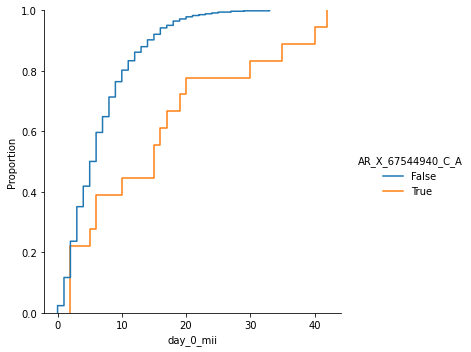

AR_X_67545395_C_-
AR_X_67545395_C_-
False    894
True      28
Name: AR_X_67545395_C_-, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

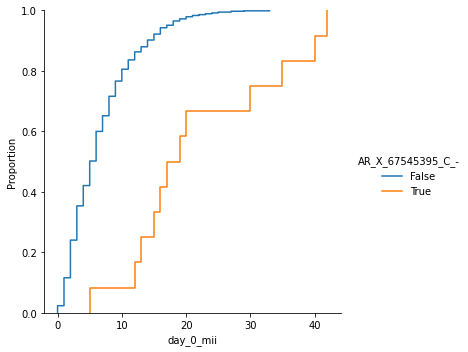

ESR2_14_64280216_-_A
ESR2_14_64280216_-_A
False    866
True      56
Name: ESR2_14_64280216_-_A, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

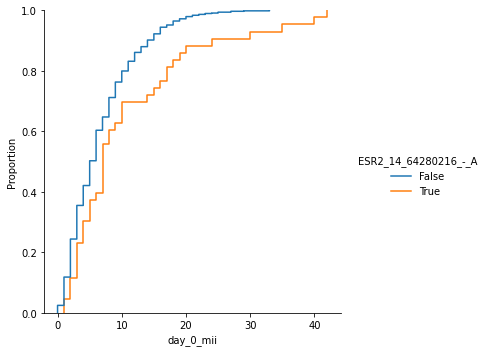

LHCGR_2_48729336_C_T
LHCGR_2_48729336_C_T
False    510
True     412
Name: LHCGR_2_48729336_C_T, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

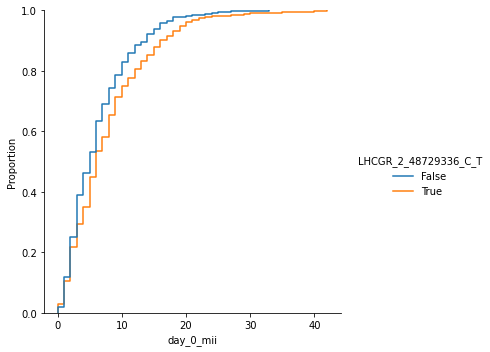

LHCGR_2_48755729_C_A
LHCGR_2_48755729_C_A
False    767
True     155
Name: LHCGR_2_48755729_C_A, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

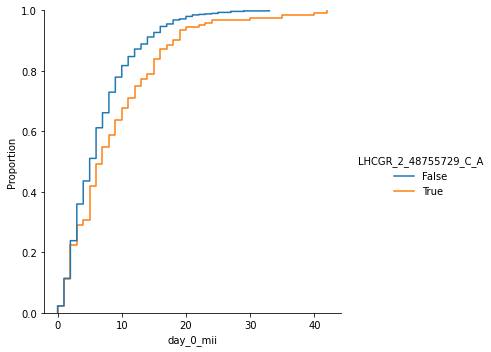

OTHER_6_22287169_A_T
OTHER_6_22287169_A_T
False    892
True      30
Name: OTHER_6_22287169_A_T, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

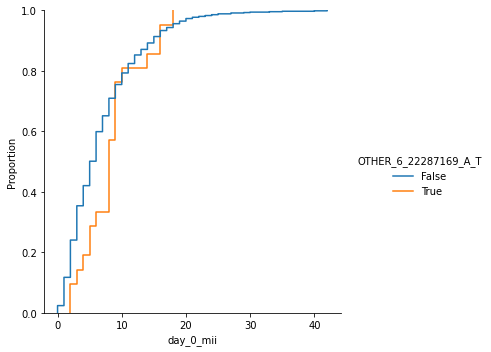

PRLR_5_35229973_C_A
PRLR_5_35229973_C_A
False    888
True      34
Name: PRLR_5_35229973_C_A, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

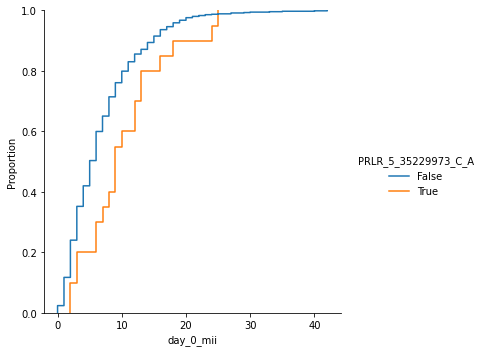

PRLR_5_35230018_C_A
PRLR_5_35230018_C_A
False    886
True      36
Name: PRLR_5_35230018_C_A, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

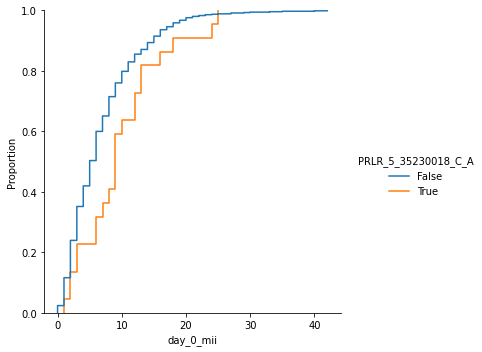

PRLR_5_35230124_G_A
PRLR_5_35230124_G_A
False    886
True      36
Name: PRLR_5_35230124_G_A, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

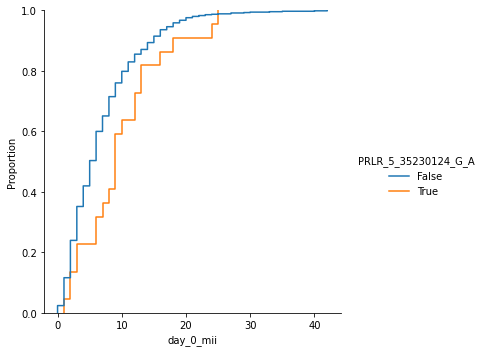

PRLR_5_35230200_G_C
PRLR_5_35230200_G_C
False    886
True      36
Name: PRLR_5_35230200_G_C, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

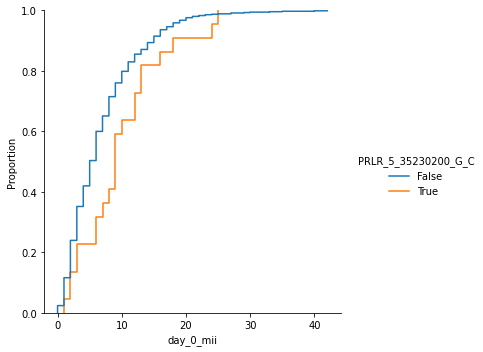

PRLR_5_35230278_G_C
PRLR_5_35230278_G_C
False    875
True      47
Name: PRLR_5_35230278_G_C, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

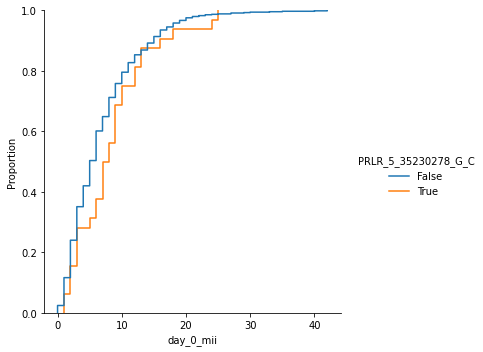

PRLR_5_35230396_G_A
PRLR_5_35230396_G_A
False    871
True      51
Name: PRLR_5_35230396_G_A, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

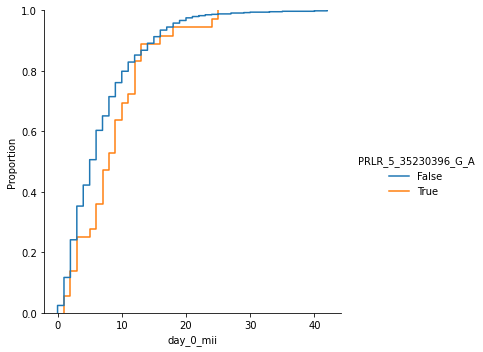

SOX9_17_72123628_C_-
SOX9_17_72123628_C_-
False    872
True      50
Name: SOX9_17_72123628_C_-, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

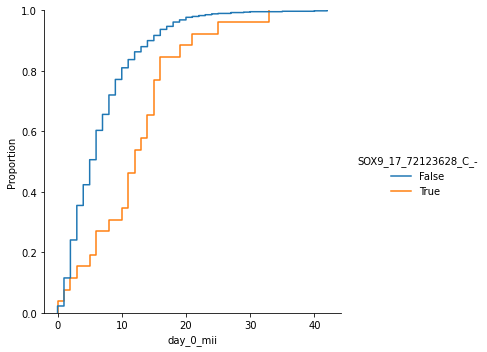

<Figure size 432x288 with 0 Axes>

In [107]:
gene_column_list = gene_columns_test.loc[(gene_columns_test['ks_less_p']<0.05)&
(gene_columns_test['count']>20),'column_name'].to_list()
for gene_column in gene_column_list:
    #sns.displot(data_900_df, x="day_0_mii", hue=gene_column, kind="kde")
    print(gene_column)
    print(data_900_df.groupby(gene_column)[gene_column].count())
    plt.figure()
    sns.displot(data_900_df, x="day_0_mii", hue=gene_column, kind="ecdf")
    plt.show()
    plt.clf()

In [127]:
gene_column_list = gene_columns_test.loc[(gene_columns_test['ks_greater_p']<0.05)&
(gene_columns_test['count']>10),'column_name'].to_list()

gene_column_list = [x for x in gene_column_list if x not in (list(set(gene_column_list).intersection(destim_cols_less_selected)))]

Original records: 922
Removed records:  268
Removed records:  0
Removed records:  0
Removed records:  14
Removed records:  92
Removed records:  18
Filtered records: 530
Original records: 922
Removed records:  268
Removed records:  0
Removed records:  0
Removed records:  30
Removed records:  90
Removed records:  18
Filtered records: 516
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in pa

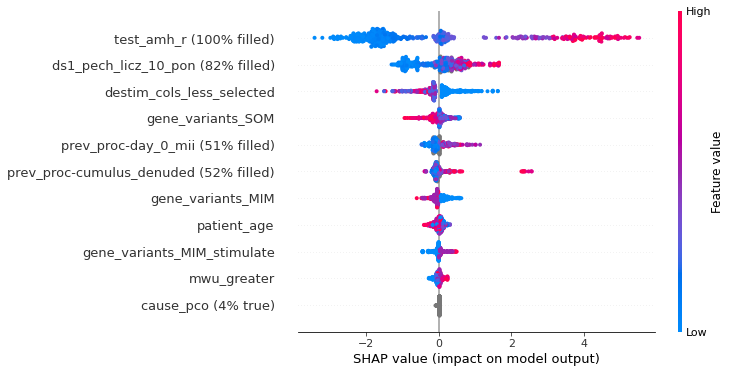

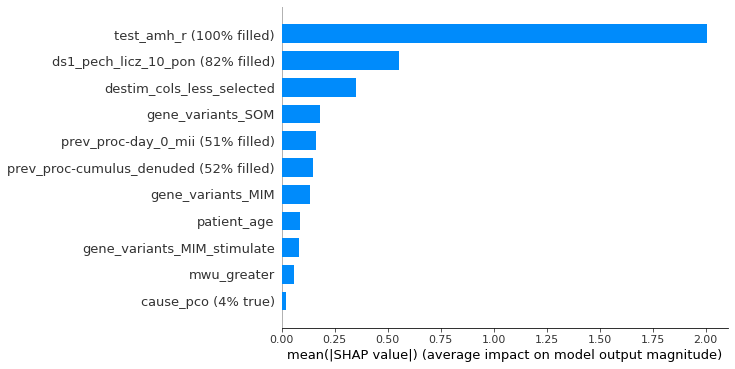

In [131]:
data_900_df['ks_greater'] = data_900_df[gene_column_list].sum(axis = 1)
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",
    'destim_cols_less_selected',
    'gene_variants_SOM',
    'gene_variants_MIM_stimulate',
    'gene_variants_MIM',
    'mwu_greater',
    #'ks_greater'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))

# Funkcja kosztu a błąd modelu dla MII

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

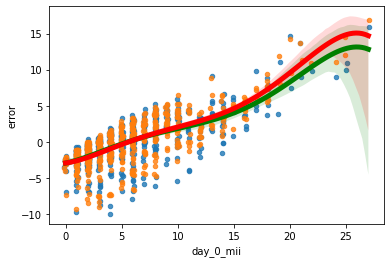

In [140]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
    'destim_cols_less_selected',
    'gene_variants_SOM',
    'gene_variants_MIM_stimulate',
    'gene_variants_MIM'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

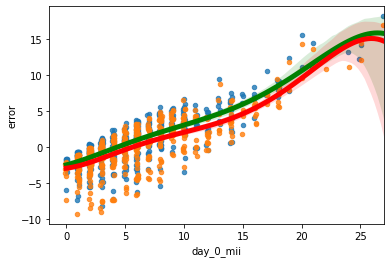

In [139]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
    #'stim_cols_less_selected',
    'destim_cols_less_selected',
    #'destim_cols_more_selected',
    #'gene_variants_ecdf',
    'gene_variants_SOM',
    'gene_variants_MIM_stimulate',
    'gene_variants_MIM'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['log_l2'])
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_log_l2']
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

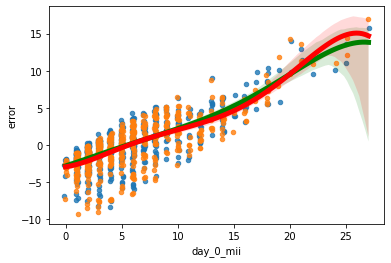

In [141]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
    'destim_cols_less_selected',
    'gene_variants_SOM',
    'gene_variants_MIM_stimulate',
    'gene_variants_MIM'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l1'])
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l1']
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

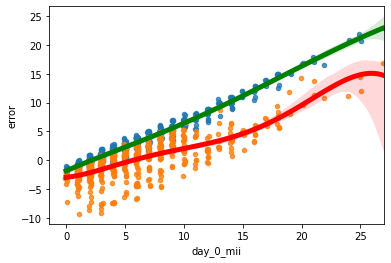

In [142]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
    'destim_cols_less_selected',
    'gene_variants_SOM',
    'gene_variants_MIM_stimulate',
    'gene_variants_MIM'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['mape'])
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_mape']
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

# Searching for optimal SOM columns

In [18]:
import itertools

def all_combinations(any_list):
    return itertools.chain.from_iterable(
        itertools.combinations(any_list, i + 1)
        for i in range(len(any_list)))

In [30]:
SOM_cols =  ['GDF9_5_132865538_T_C', 
            'GDF9_5_132866205_T_C',
            'PRL_6_22292747_A_T', 
            'AR_X_67723521_-_CACACAC',
            'LHCGR_2_48729336_C_T',
            'FSHB_11_30234435_A_G',
            'FSHR_2_48963902_C_T___Missense Variant',
            'ESR1_6_152098960_G_A',
            'ESR1_6_152061190_A_G',
            'PRLR_5_35069955_T_A',
            'ESR2_14_64227477_C_T']
        


In [29]:
ETA_900 = 0.5

0it [00:00, ?it/s]# Number of column combinations: 2047
# ETA: 1:08:14
2047it [1:24:19,  2.47s/it]=====================================
model: l2
sorted_by: RMSE



index         0
0  RMSE_900_cumulus_denuded -0.145706
1        RMSE_900_day_0_mii -0.170275

RMSE_900_cumulus_denuded


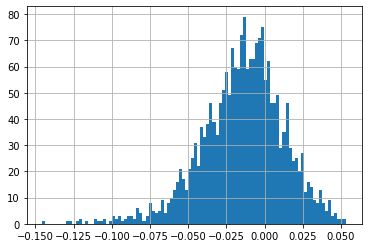

RMSE_900_day_0_mii


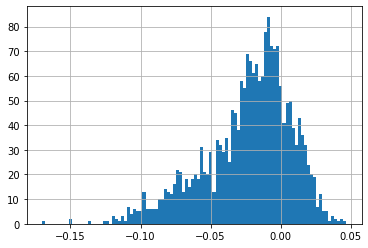

In [137]:
results_combinations_SOM = train_generated_cols_sum(
    all_combinations(SOM_cols),
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    BASE_COLS_2, REF_RESULTS,
    'l2', 'RMSE',
    10, ETA_900)

In [107]:
data_900_df['SOM_cols'] = data_900_df[["GDF9_5_132865538_T_C", "GDF9_5_132866205_T_C", "PRL_6_22292747_A_T", "AR_X_67723521_-_CACACAC", "LHCGR_2_48729336_C_T", "FSHB_11_30234435_A_G", "ESR1_6_152061190_A_G", "ESR2_14_64227477_C_T"]].sum(axis = 1)

In [113]:
data_900_df['SOM_cols'] = data_900_df[["GDF9_5_132865538_T_C", "GDF9_5_132866205_T_C", "LHCGR_2_48729336_C_T", "ESR1_6_152098960_G_A", "ESR1_6_152061190_A_G", "ESR2_14_64227477_C_T"]].sum(axis = 1)

In [110]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


In [111]:
LGB_PARAMS_BASE, N_FOLDS, ALL_MODEL_SUFFIXES, BASE_COLS_1, BASE_COLS_2, ranking_cols = get_consts()

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   4.30    (0.00)    
MAE[ test_fold_avg][l2][900_cumulus_denuded]:  count:516    avg:7.67   3.13    (0.00)    
MAPE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   0.76    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   5.52    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.37    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.49    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.68    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


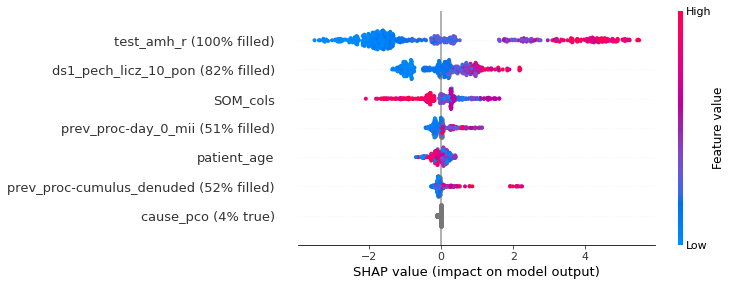

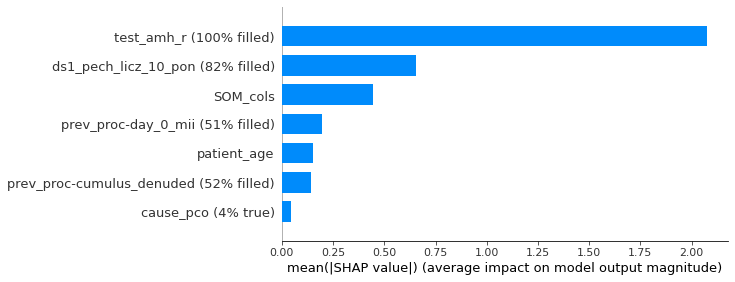

<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

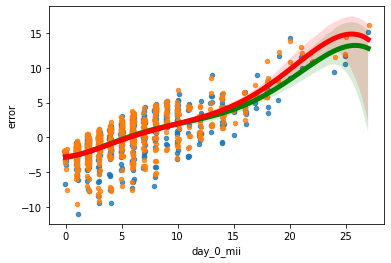

In [112]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
    "SOM_cols"
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
-
RMSE[ test_fold_av

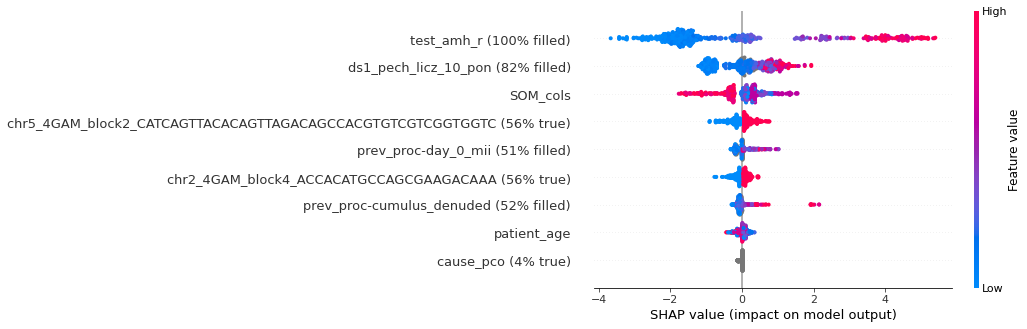

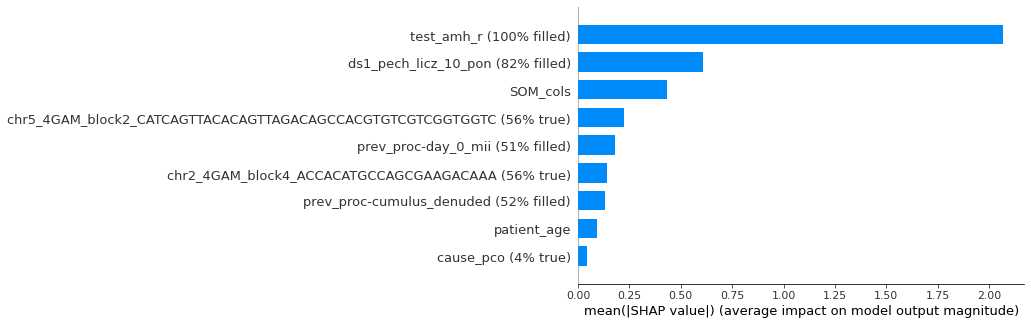

<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

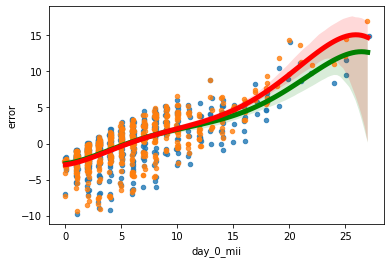

In [316]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
   "SOM_cols", "chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA", "chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC"
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

# Searching for optimal Haplotypes

In [10]:
haplotypes_to_zip = ["chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA", "chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC", "chr5_4GAM_block6_AGTGTTCTGGACGGCC"]

In [11]:
def get_position(x: str):
    return x.split("_")[2]

In [12]:
def get_variants_from_haplotypes(DATA_PATH: str,chr: str,method: str,block: int,variants_list: list, haplotype:str):
    blocks, haplotypes = read_haploview_file(
        f"{DATA_PATH}/poprawne_vcf_haplotypes/haplotypes/hmap/hmap_invicta.{chr}.hmap.{method}blocks",
        False,
    )
    patient_ids, locus_infos, locus_dict, patient_genome = \
        read_hmap_file(f"{DATA_PATH}/poprawne_vcf_haplotypes/haplotypes/hmap/hmap_invicta.{chr}.hmap")
    positions = []
    for i in blocks[block]:
        positions.append(int(locus_infos[i-1].pos))
    chr2_variants_cols = [x for x in variants_list if int(x.split('_')[3]) in positions]
    sorted_ch2_variants_cols = sorted(chr2_variants_cols,key=get_position)
    return(positions,dict(zip(sorted_ch2_variants_cols,list(haplotype.split("_")[3]))))

In [13]:
GENOME_COLS = [col for col in data_900_df.columns if col[:6]=='genome']

In [14]:
len(GENOME_COLS)

633

In [15]:
data_900_df[GENOME_COLS] = (data_900_df[GENOME_COLS] >0)*1

In [16]:
chr2_4GAM_block4_positions, chr2_4GAM_block4_haplotypes_variants =  get_variants_from_haplotypes(DATA_PATH,'chr2','4GAM',4,GENOME_COLS,"chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA")

In [17]:
chr2_4GAM_block4_haplotypes_variants

{'genome_012_chr2_48755846_A_G': 'A',
 'genome_012_chr2_48961885_C_T': 'C',
 'genome_012_chr2_48962033_C_T': 'C',
 'genome_012_chr2_48962060_A_G': 'A',
 'genome_012_chr2_48962210_C_T': 'C',
 'genome_012_chr2_48962487_A_T': 'A',
 'genome_012_chr2_48962782_C_T': 'T',
 'genome_012_chr2_48963138_G_A': 'G',
 'genome_012_chr2_48963491_C_T': 'C',
 'genome_012_chr2_48963599_C_A': 'C',
 'genome_012_chr2_48963670_A_G': 'A',
 'genome_012_chr2_48963773_G_T': 'G',
 'genome_012_chr2_48963859_C_G': 'C',
 'genome_012_chr2_48968573_G_C': 'G',
 'genome_012_chr2_48968886_A_G': 'A',
 'genome_012_chr2_48982928_A_C': 'A',
 'genome_012_chr2_48982977_G_A': 'G',
 'genome_012_chr2_48988980_A_G': 'A',
 'genome_012_chr2_48989016_C_T': 'C',
 'genome_012_chr2_48989135_A_T': 'A',
 'genome_012_chr2_48990555_A_G': 'A',
 'genome_012_chr2_48990619_A_G': 'A'}

In [18]:
chr5_4GAM_block2_positions, chr5_4GAM_block2_haplotypes_variants =  get_variants_from_haplotypes(DATA_PATH,'chr5','4GAM',2,GENOME_COLS,"chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC")

In [19]:
chr5_4GAM_block2_haplotypes_variants

{'genome_012_chr5_35060399_C_T': 'C',
 'genome_012_chr5_35060411_A_G': 'A',
 'genome_012_chr5_35060629_T_C': 'T',
 'genome_012_chr5_35060923_C_A': 'C',
 'genome_012_chr5_35061009_A_G': 'A',
 'genome_012_chr5_35061154_G_T': 'G',
 'genome_012_chr5_35061629_T_C': 'T',
 'genome_012_chr5_35061761_T_C': 'T',
 'genome_012_chr5_35061871_A_G': 'A',
 'genome_012_chr5_35061973_C_T': 'C',
 'genome_012_chr5_35062253_A_T': 'A',
 'genome_012_chr5_35062516_C_T': 'C',
 'genome_012_chr5_35062627_A_G': 'A',
 'genome_012_chr5_35063008_G_A': 'G',
 'genome_012_chr5_35063015_T_C': 'T',
 'genome_012_chr5_35063098_T_C': 'T',
 'genome_012_chr5_35063190_A_T': 'A',
 'genome_012_chr5_35063323_G_A': 'G',
 'genome_012_chr5_35064072_A_G': 'A',
 'genome_012_chr5_35064118_C_G': 'C',
 'genome_012_chr5_35064133_A_G': 'A',
 'genome_012_chr5_35064358_G_C': 'G',
 'genome_012_chr5_35064413_C_A': 'C',
 'genome_012_chr5_35064637_C_T': 'C',
 'genome_012_chr5_35064682_A_G': 'A',
 'genome_012_chr5_35064922_C_G': 'C',
 'genome_012

In [20]:
chr5_4GAM_block6_positions, chr5_4GAM_block6_haplotypes_variants =  get_variants_from_haplotypes(DATA_PATH,'chr5','4GAM',6,GENOME_COLS,"chr5_4GAM_block6_AGTGTTCTGGACGGCC")

In [21]:
chr5_4GAM_block6_haplotypes_variants

{'genome_012_chr5_132865408_A_G': 'A',
 'genome_012_chr5_132865453_G_A': 'G',
 'genome_012_chr5_132865691_T_C': 'T',
 'genome_012_chr5_132866060_G_A': 'G',
 'genome_012_chr5_132866082_T_A': 'T',
 'genome_012_chr5_132866205_T_C': 'T',
 'genome_012_chr5_132866215_C_T': 'C',
 'genome_012_chr5_132866313_T_A': 'T',
 'genome_012_chr5_132866484_G_C': 'G',
 'genome_012_chr5_132866553_G_A': 'G',
 'genome_012_chr5_132866657_A_C': 'A',
 'genome_012_chr5_132866707_T_C': 'C',
 'genome_012_chr5_132866719_C_G': 'G',
 'genome_012_chr5_132866743_G_A': 'G',
 'genome_012_chr5_132866746_C_T': 'C',
 'genome_012_chr5_132867052_C_T': 'C'}

In [22]:
data_900_df['genome_012_chr2_48755846_A_G'].sum()

7

In [23]:
data_900_df[GENOME_COLS]

genome_012_chr11_30230704_A_T  genome_012_chr11_30230805_G_T  \
0                                0                              0   
1                                0                              0   
2                                0                              0   
3                                0                              0   
4                                0                              0   
..                             ...                            ...   
901                              0                              1   
902                              0                              1   
903                              0                              1   
904                              0                              1   
905                              0                              1   

     genome_012_chr11_30231014_C_G  genome_012_chr11_30231089_CT_C  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   
..                             ...                             ...   
901                              0                               0   
902                              0                               0   
903                              0                               0   
904                              0                               0   
905                              0                               0   

     genome_012_chr11_30231771_A_T  genome_012_chr11_30231961_G_T  \
0                                1                              0   
1                                1                              0   
2                                1                              0   
3                                0                              0   
4                                0                              0   
..                             ...                            ...   
901                              1                              0   
902                              1                              0   
903                              1                              0   
904                              1                              0   
905                              1                              0   

     genome_012_chr11_30232094_T_C  genome_012_chr11_30233511_C_T  \
0                                1                              0   
1                                1                              0   
2                                1                              0   
3                                0                              0   
4                                0                              0   
..                             ...                            ...   
901                              1                              0   
902                              1                              0   
903                              1                              0   
904                              1                              0   
905                              1                              0   

     genome_012_chr11_30233638_C_T  genome_012_chr11_30233737_C_A  \
0                                1                              0   
1                                1                              0   
2                                1                              0   
3                                0                              0   
4                                0                              0   
..                             ...                            ...   
901                              1                              0   
902                              1                              0   
903                              1                      

In [24]:
import umap
import umap.plot

In [25]:
import sklearn.cluster as cluster

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
from sklearn import tree

In [49]:
chr5_4GAM_block6_haplotypes_variants

{'genome_012_chr5_132865408_A_G': 'A',
 'genome_012_chr5_132865453_G_A': 'G',
 'genome_012_chr5_132865691_T_C': 'T',
 'genome_012_chr5_132866060_G_A': 'G',
 'genome_012_chr5_132866082_T_A': 'T',
 'genome_012_chr5_132866205_T_C': 'T',
 'genome_012_chr5_132866215_C_T': 'C',
 'genome_012_chr5_132866313_T_A': 'T',
 'genome_012_chr5_132866484_G_C': 'G',
 'genome_012_chr5_132866553_G_A': 'G',
 'genome_012_chr5_132866657_A_C': 'A',
 'genome_012_chr5_132866707_T_C': 'C',
 'genome_012_chr5_132866719_C_G': 'G',
 'genome_012_chr5_132866743_G_A': 'G',
 'genome_012_chr5_132866746_C_T': 'C',
 'genome_012_chr5_132867052_C_T': 'C'}

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


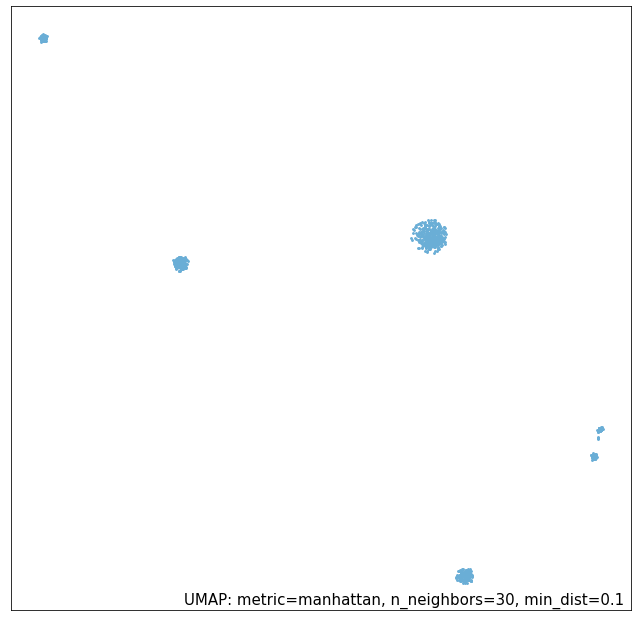

In [44]:
haplo_data = data_900_df[pd.DataFrame.from_dict(chr5_4GAM_block6_haplotypes_variants,orient='index').index.to_list()].copy()
haplo_data = haplo_data.applymap(lambda x: (x>0)*1)
u = umap.UMAP(metric='manhattan',n_neighbors=30).fit(haplo_data)
umap.plot.points(
    u, 
    #labels=DATA_SERIES_900['900_day_0_mii'].input_df['day_0_mii'], 
    color_key_cmap='Paired')
umap_values = umap.UMAP(metric='manhattan',n_neighbors=30).fit_transform(haplo_data)

<AxesSubplot:>

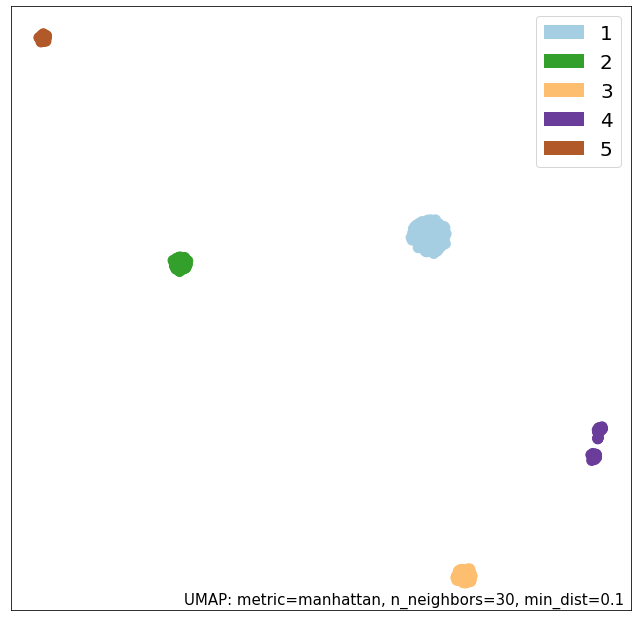

In [45]:
clusters = cluster.KMeans(n_clusters=5).fit_predict(umap_values)
dt = DecisionTreeClassifier()
dt.fit(haplo_data, clusters)
umap.plot.points(
    u, 
    labels=(clusters+1), 
    color_key_cmap='Paired',
    point_size = 100)

In [28]:
clusters = cluster.KMeans(n_clusters=5).fit_predict(umap_values)
dt = DecisionTreeClassifier()
dt.fit(haplo_data, clusters)

DecisionTreeClassifier()

[Text(186.0, 195.696, 'X[4] <= 0.5\ngini = 0.721\nsamples = 914\nvalue = [402, 170, 157, 112, 73]'),
 Text(111.60000000000001, 152.208, 'X[5] <= 0.5\ngini = 0.528\nsamples = 644\nvalue = [402, 170, 0, 0, 72]'),
 Text(74.4, 108.72, 'X[11] <= 0.5\ngini = 0.258\nsamples = 474\nvalue = [402, 0, 0, 0, 72]'),
 Text(37.2, 65.232, 'gini = 0.0\nsamples = 72\nvalue = [0, 0, 0, 0, 72]'),
 Text(111.60000000000001, 65.232, 'gini = 0.0\nsamples = 402\nvalue = [402, 0, 0, 0, 0]'),
 Text(148.8, 108.72, 'gini = 0.0\nsamples = 170\nvalue = [0, 170, 0, 0, 0]'),
 Text(260.40000000000003, 152.208, 'X[5] <= 0.5\ngini = 0.49\nsamples = 270\nvalue = [0, 0, 157, 112, 1]'),
 Text(223.20000000000002, 108.72, 'X[15] <= 0.5\ngini = 0.361\nsamples = 205\nvalue = [0, 0, 157, 47, 1]'),
 Text(186.0, 65.232, 'X[11] <= 0.5\ngini = 0.013\nsamples = 158\nvalue = [0, 0, 157, 0, 1]'),
 Text(148.8, 21.744, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 0, 1]'),
 Text(223.20000000000002, 21.744, 'gini = 0.0\nsamples = 157\nvalue

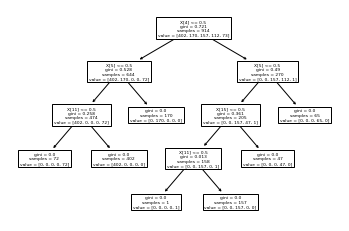

In [39]:
tree.plot_tree(dt)

In [40]:
haplo_data.iloc[:,[4,5,12]].columns.to_list()

['genome_012_chr5_132866082_T_A',
 'genome_012_chr5_132866205_T_C',
 'genome_012_chr5_132866719_C_G']

In [41]:
data_900_df['chr5_4GAM_block6_haplotypes_variants'] = ((haplo_data.iloc[:,[4,5]].sum(axis=1)==0)&(haplo_data.iloc[:,12]==1))*1

In [326]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
-
RMSE[ test_fold_av

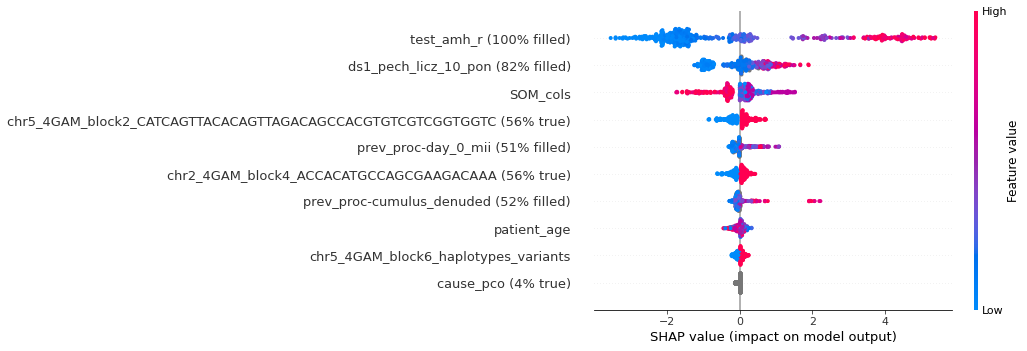

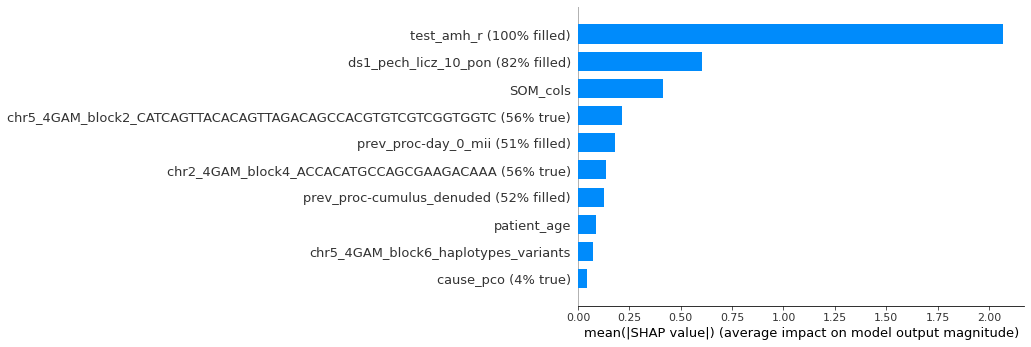

<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

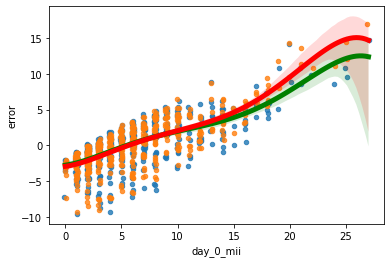

In [327]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
   "SOM_cols", "chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA", "chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC", "chr5_4GAM_block6_haplotypes_variants"
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


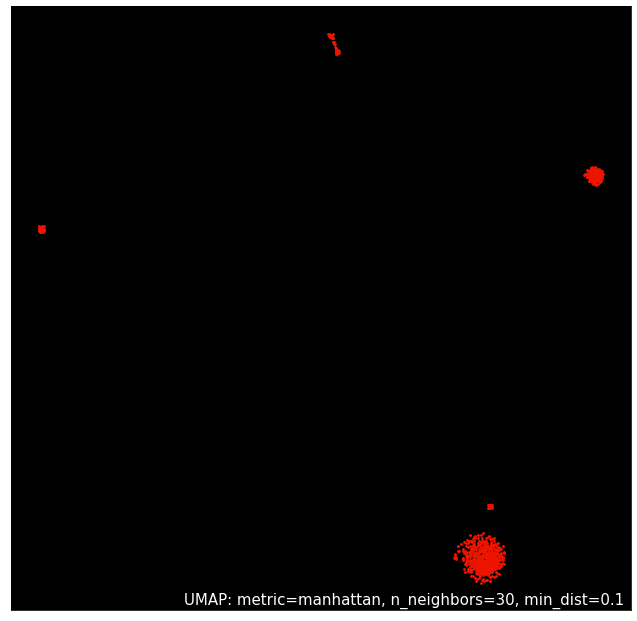

In [46]:
haplo_data = data_900_df[pd.DataFrame.from_dict(chr2_4GAM_block4_haplotypes_variants,orient='index').index.to_list()].copy()
haplo_data = haplo_data.applymap(lambda x: (x>0)*1)
u = umap.UMAP(metric='manhattan',n_neighbors=30).fit(haplo_data)
umap.plot.points(
    u, 
    #labels=DATA_SERIES_900['900_day_0_mii'].input_df['day_0_mii'], 
    color_key_cmap='Paired', 
    theme='fire')
umap_values = umap.UMAP(metric='manhattan',n_neighbors=30).fit_transform(haplo_data)

<AxesSubplot:>

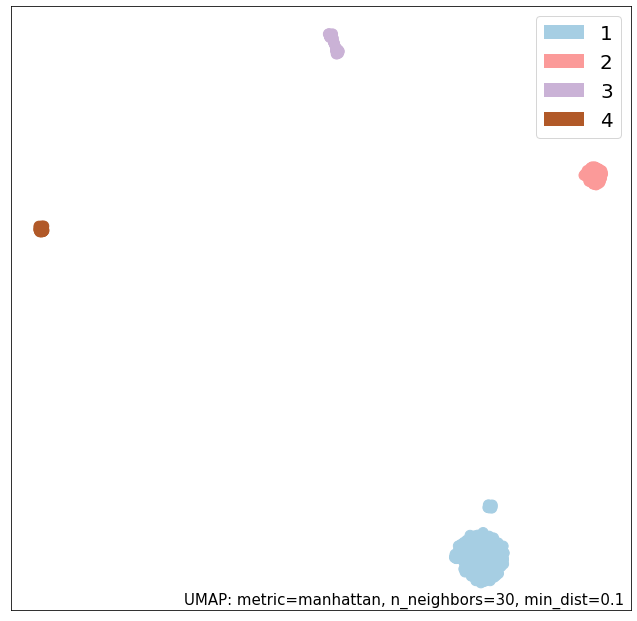

In [48]:
clusters = cluster.KMeans(n_clusters=4).fit_predict(umap_values)
dt = DecisionTreeClassifier()
dt.fit(haplo_data, clusters)
umap.plot.points(
    u, 
    labels=(clusters+1), 
    color_key_cmap='Paired',
    point_size = 100)

In [32]:
clusters = cluster.KMeans(n_clusters=3).fit_predict(umap_values)
dt = DecisionTreeClassifier()
dt.fit(haplo_data, clusters)

DecisionTreeClassifier()

[Text(133.92000000000002, 181.2, 'X[6] <= 0.5\ngini = 0.475\nsamples = 914\nvalue = [611, 250, 53]'),
 Text(66.96000000000001, 108.72, 'gini = 0.0\nsamples = 250\nvalue = [0, 250, 0]'),
 Text(200.88000000000002, 108.72, 'X[3] <= 0.5\ngini = 0.147\nsamples = 664\nvalue = [611, 0, 53]'),
 Text(133.92000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 611\nvalue = [611, 0, 0]'),
 Text(267.84000000000003, 36.23999999999998, 'gini = 0.0\nsamples = 53\nvalue = [0, 0, 53]')]

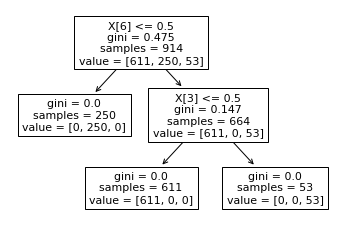

In [31]:
tree.plot_tree(dt)

In [32]:
data_900_df['chr2_4GAM_block4_haplotypes_variants'] = ((haplo_data.iloc[:,6]==1)&(haplo_data.iloc[:,3]==0))*1

In [86]:
data_900_df['chr2_4GAM_block4_haplotypes_variants'] = ((data_900_df['genome_012_chr2_48962782_C_T']==1)&(data_900_df['genome_012_chr2_48962060_A_G']==0))*1

In [36]:
haplo_data.iloc[:,[6,3]].columns.to_list()

['genome_012_chr2_48962782_C_T', 'genome_012_chr2_48962060_A_G']

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
-
RMSE[ test_fold_av

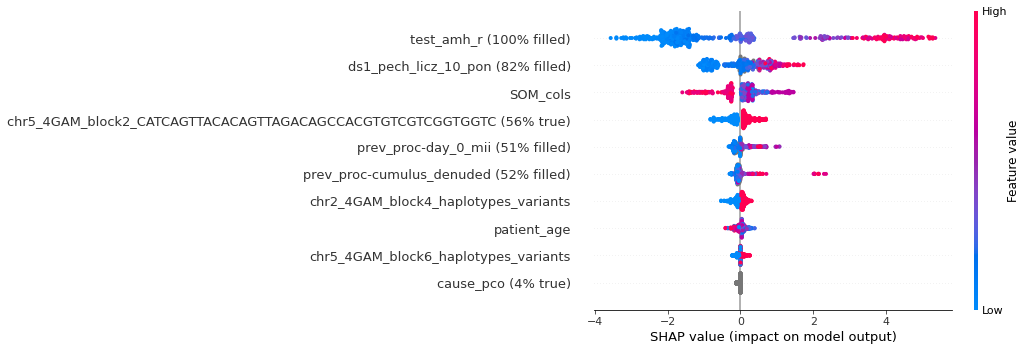

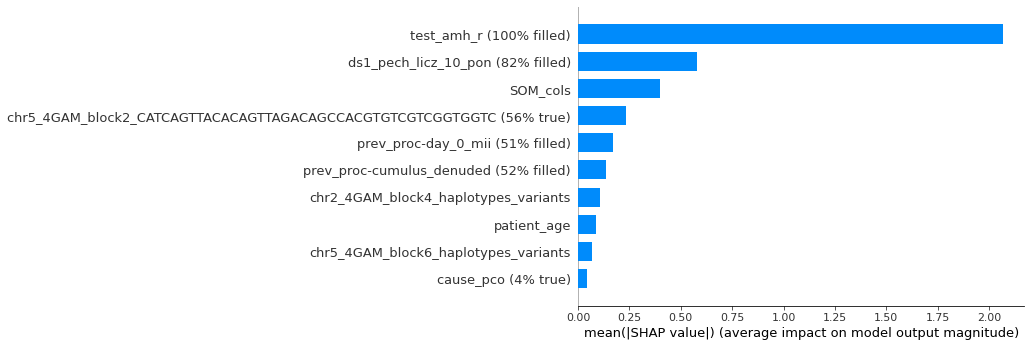

NameError: name 'REF_RESULTS_df' is not defined

In [44]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
   "SOM_cols", "chr2_4GAM_block4_haplotypes_variants", "chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC", "chr5_4GAM_block6_haplotypes_variants"
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

In [29]:
haplo_data = DATA_SERIES_900['900_day_0_mii'].input_df[pd.DataFrame.from_dict(chr5_4GAM_block2_haplotypes_variants,orient='index').index.to_list()].copy()
haplo_data = haplo_data.applymap(lambda x: (x>0)*1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


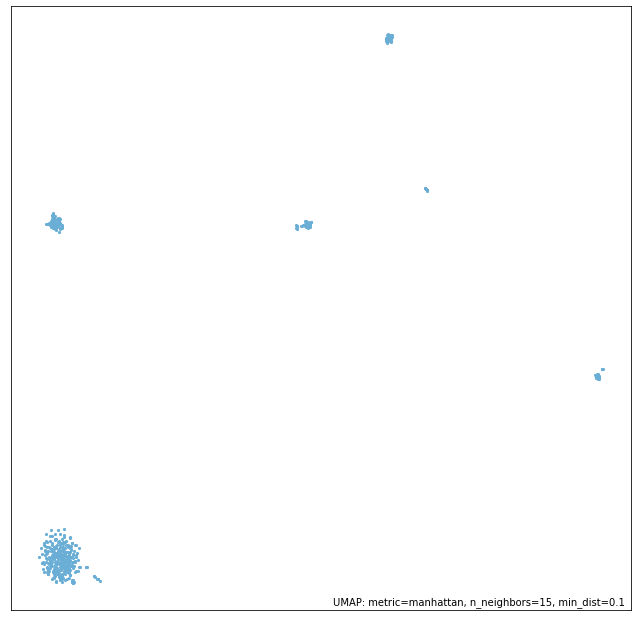

In [30]:
u = umap.UMAP(metric='manhattan').fit(haplo_data)
umap.plot.points(
    u, 
    #labels=DATA_SERIES_900['900_day_0_mii'].input_df['day_0_mii'], 
    color_key_cmap='Paired')
umap_values = umap.UMAP(metric='manhattan').fit_transform(haplo_data)

In [31]:
clusters = cluster.KMeans(n_clusters=6).fit_predict(umap_values)
dt = DecisionTreeClassifier()
dt.fit(haplo_data, clusters)

DecisionTreeClassifier()

Trying to register the cmap 'fire' which already exists.
Trying to register the cmap 'darkblue' which already exists.
Trying to register the cmap 'darkgreen' which already exists.
Trying to register the cmap 'darkred' which already exists.
Trying to register the cmap 'darkpurple' which already exists.


<AxesSubplot:>

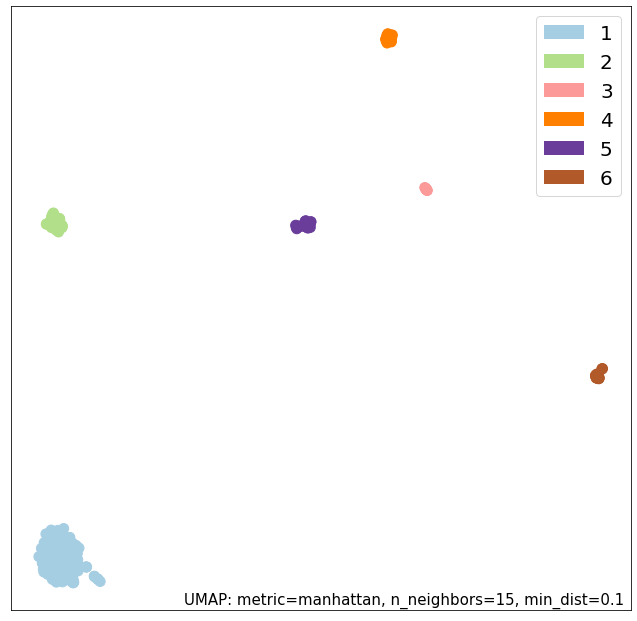

In [43]:
umap.plot.points(
    u, 
    labels=(clusters+1), 
    color_key_cmap='Paired',
    point_size = 100)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


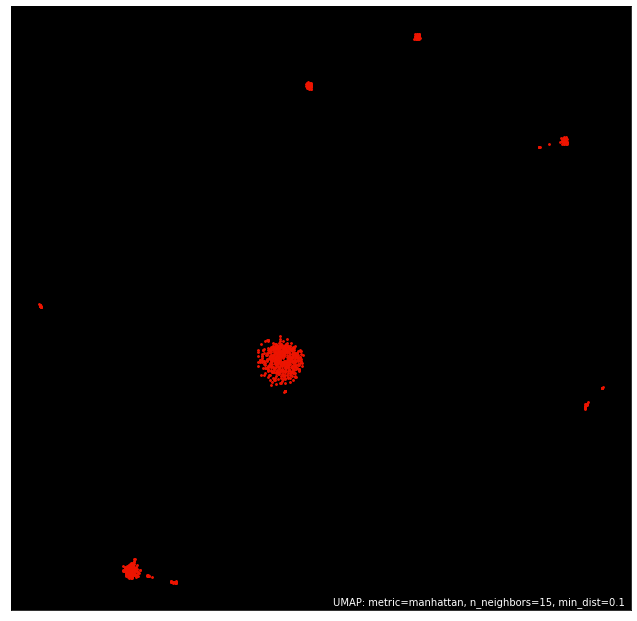

In [45]:
haplo_data = data_900_df[pd.DataFrame.from_dict(chr5_4GAM_block2_haplotypes_variants,orient='index').index.to_list()].copy()
haplo_data = haplo_data.applymap(lambda x: (x>0)*1)
u = umap.UMAP(metric='manhattan').fit(haplo_data)
umap.plot.points(
    u, 
    #labels=DATA_SERIES_900['900_day_0_mii'].input_df['day_0_mii'], 
    color_key_cmap='Paired', 
    theme='fire')
umap_values = umap.UMAP(metric='manhattan').fit_transform(haplo_data)

In [79]:
clusters = cluster.KMeans(n_clusters=6).fit_predict(umap_values)
dt = DecisionTreeClassifier()
dt.fit(haplo_data, clusters)

DecisionTreeClassifier()

<AxesSubplot:>

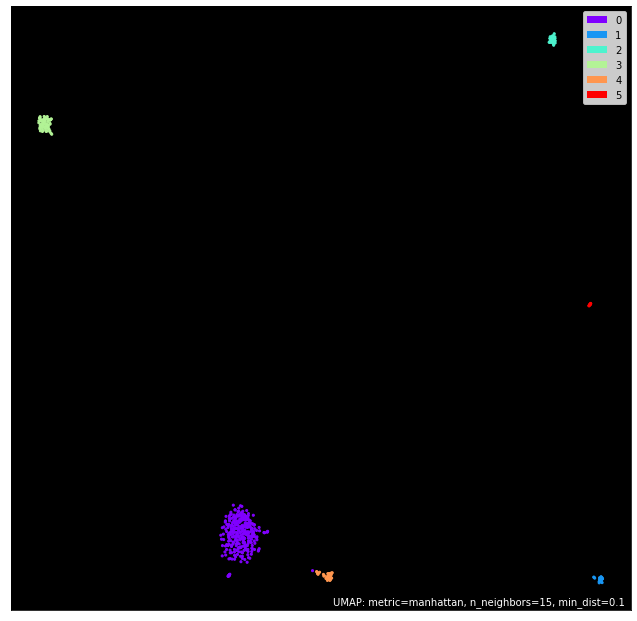

In [80]:
umap.plot.points(
    u, 
    labels=clusters, 
    color_key_cmap='Paired', 
    theme='fire')

<AxesSubplot:>

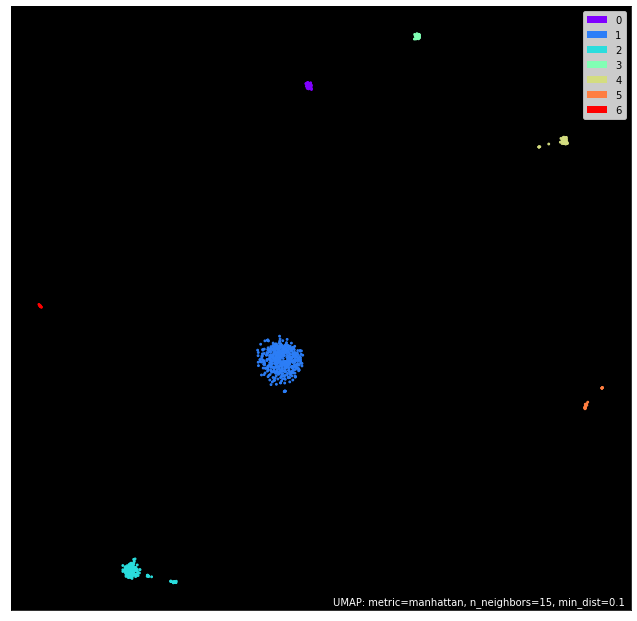

In [47]:
umap.plot.points(
    u, 
    labels=clusters, 
    color_key_cmap='Paired', 
    theme='fire')

[Text(178.56, 195.696, 'X[16] <= 0.5\ngini = 0.58\nsamples = 516\nvalue = [319, 27, 40, 76, 43, 11]'),
 Text(111.6, 152.208, 'X[25] <= 0.5\ngini = 0.337\nsamples = 396\nvalue = [319, 24, 40, 4, 0, 9]'),
 Text(89.28, 108.72, 'X[33] <= 0.5\ngini = 0.192\nsamples = 356\nvalue = [319, 24, 0, 4, 0, 9]'),
 Text(44.64, 65.232, 'X[11] <= 0.5\ngini = 0.024\nsamples = 323\nvalue = [319, 0, 0, 4, 0, 0]'),
 Text(22.32, 21.744, 'gini = 0.0\nsamples = 319\nvalue = [319, 0, 0, 0, 0, 0]'),
 Text(66.96000000000001, 21.744, 'gini = 0.0\nsamples = 4\nvalue = [0, 0, 0, 4, 0, 0]'),
 Text(133.92000000000002, 65.232, 'X[21] <= 0.5\ngini = 0.397\nsamples = 33\nvalue = [0, 24, 0, 0, 0, 9]'),
 Text(111.6, 21.744, 'gini = 0.0\nsamples = 9\nvalue = [0, 0, 0, 0, 0, 9]'),
 Text(156.24, 21.744, 'gini = 0.0\nsamples = 24\nvalue = [0, 24, 0, 0, 0, 0]'),
 Text(133.92000000000002, 108.72, 'gini = 0.0\nsamples = 40\nvalue = [0, 0, 40, 0, 0, 0]'),
 Text(245.52, 152.208, 'X[6] <= 0.5\ngini = 0.511\nsamples = 120\nvalue = [

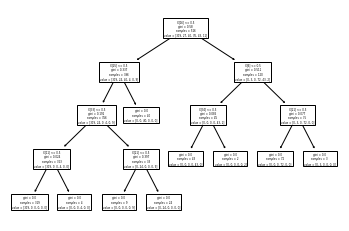

In [81]:
tree.plot_tree(dt)

[Text(203.27142857142857, 201.90857142857143, 'X[16] <= 0.5\ngini = 0.608\nsamples = 914\nvalue = [27, 538, 168, 62, 55, 45, 19]'),
 Text(135.5142857142857, 170.84571428571428, 'X[25] <= 0.5\ngini = 0.369\nsamples = 685\nvalue = [17, 538, 4, 62, 0, 45, 19]'),
 Text(95.65714285714286, 139.78285714285715, 'X[34] <= 0.5\ngini = 0.257\nsamples = 627\nvalue = [17, 538, 4, 5, 0, 44, 19]'),
 Text(63.77142857142857, 108.72, 'X[37] <= 0.5\ngini = 0.095\nsamples = 566\nvalue = [0, 538, 4, 5, 0, 0, 19]'),
 Text(47.82857142857143, 77.65714285714284, 'X[22] <= 0.5\ngini = 0.032\nsamples = 547\nvalue = [0, 538, 4, 5, 0, 0, 0]'),
 Text(31.885714285714286, 46.59428571428572, 'X[11] <= 0.5\ngini = 0.015\nsamples = 542\nvalue = [0, 538, 4, 0, 0, 0, 0]'),
 Text(15.942857142857143, 15.531428571428563, 'gini = 0.0\nsamples = 538\nvalue = [0, 538, 0, 0, 0, 0, 0]'),
 Text(47.82857142857143, 15.531428571428563, 'gini = 0.0\nsamples = 4\nvalue = [0, 0, 4, 0, 0, 0, 0]'),
 Text(63.77142857142857, 46.594285714285

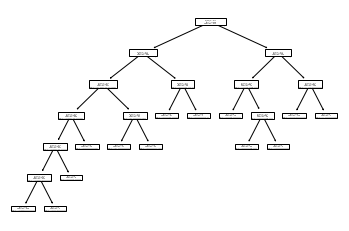

In [346]:
tree.plot_tree(dt)

In [409]:
data_900_df['chr5_4GAM_block2_haplotypes_variants'].sum()

519

In [398]:
data_900_df['chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC'].sum()

496

In [96]:
haplo_data.shape

(516, 41)

In [392]:
data_900_df.loc[(data_900_df['chr5_4GAM_block2_haplotypes_variants']==1)&(data_900_df['chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC']==0)][haplo_data.columns].sum()

genome_012_chr5_35060399_C_T    0
genome_012_chr5_35060411_A_G    0
genome_012_chr5_35060629_T_C    0
genome_012_chr5_35060923_C_A    5
genome_012_chr5_35061009_A_G    0
genome_012_chr5_35061154_G_T    3
genome_012_chr5_35061629_T_C    0
genome_012_chr5_35061761_T_C    0
genome_012_chr5_35061871_A_G    0
genome_012_chr5_35061973_C_T    3
genome_012_chr5_35062253_A_T    2
genome_012_chr5_35062516_C_T    0
genome_012_chr5_35062627_A_G    1
genome_012_chr5_35063008_G_A    1
genome_012_chr5_35063015_T_C    0
genome_012_chr5_35063098_T_C    2
genome_012_chr5_35063190_A_T    0
genome_012_chr5_35063323_G_A    0
genome_012_chr5_35064072_A_G    0
genome_012_chr5_35064118_C_G    0
genome_012_chr5_35064133_A_G    0
genome_012_chr5_35064358_G_C    0
genome_012_chr5_35064413_C_A    0
genome_012_chr5_35064637_C_T    0
genome_012_chr5_35064682_A_G    1
genome_012_chr5_35064922_C_G    0
genome_012_chr5_35065026_G_A    2
genome_012_chr5_35065030_T_C    0
genome_012_chr5_35065384_G_A    0
genome_012_chr

In [48]:
data_900_df['chr5_4GAM_block2_haplotypes_variants'] = ((haplo_data.iloc[:,[16,25,34,6,37,22,11,30]].sum(axis=1)==0))*1

In [83]:
data_900_df['chr5_4GAM_block2_haplotypes_variants'] = ((haplo_data.iloc[:,[16,25,34,37,22,11,30]].sum(axis=1)==0))*1

In [82]:
haplo_data.iloc[:,6]

0      0
1      0
2      0
3      0
4      0
      ..
820    0
821    0
822    0
824    0
825    0
Name: genome_012_chr5_35061629_T_C, Length: 516, dtype: int64

In [92]:
data_900_df['chr5_4GAM_block2_haplotypes_variants'] = (data_900_df[[
 'genome_012_chr5_35063190_A_T',
 'genome_012_chr5_35064922_C_G',
 'genome_012_chr5_35068146_G_C',
 #'genome_012_chr5_35061629_T_C',
 'genome_012_chr5_35069864_G_A',
 'genome_012_chr5_35064413_C_A',
 'genome_012_chr5_35062516_C_T',
 'genome_012_chr5_35065548_C_T'
 ]].sum(axis = 1)==0)*1

In [93]:
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


In [76]:
pd.crosstab(DATA_SERIES_900['900_day_0_mii'].input_df['chr5_4GAM_block2_haplotypes_variants'],DATA_SERIES_900['900_day_0_mii'].input_df['chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC']*1)

chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC    0    1
chr5_4GAM_block2_haplotypes_variants                                
0                                                           212    0
1                                                            17  287

In [49]:
haplo_data.iloc[:,[16,25,34,6,37,22,11,30]].columns.to_list()

['genome_012_chr5_35063190_A_T',
 'genome_012_chr5_35064922_C_G',
 'genome_012_chr5_35068146_G_C',
 'genome_012_chr5_35061629_T_C',
 'genome_012_chr5_35069864_G_A',
 'genome_012_chr5_35064413_C_A',
 'genome_012_chr5_35062516_C_T',
 'genome_012_chr5_35065548_C_T']

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   4.30    (0.00)    
MAE[ test_fold_avg][l2][900_cumulus_denuded]:  count:516    avg:7.67   3.12    (0.00)    
MAPE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   0.76    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   5.52    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.35    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.49    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.69    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


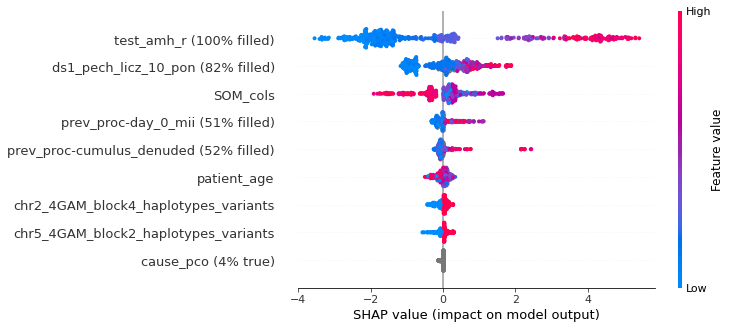

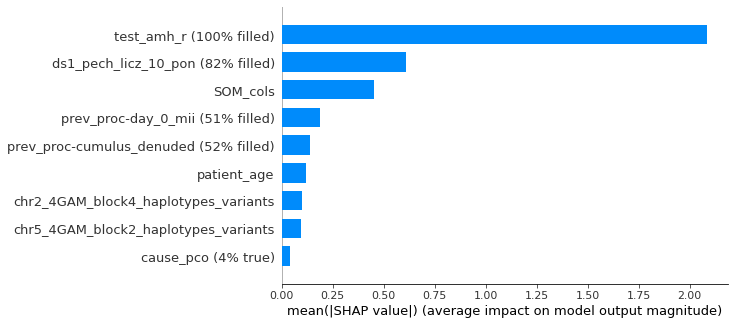

<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

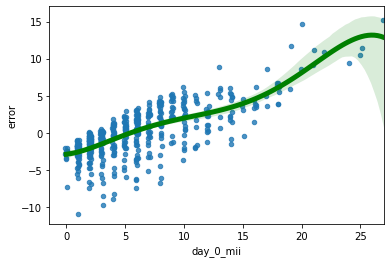

In [107]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
   "SOM_cols",
   "chr2_4GAM_block4_haplotypes_variants", 
   "chr5_4GAM_block2_haplotypes_variants", 
   #"chr5_4GAM_block6_haplotypes_variants"
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)

In [23]:
len(GENOME_COLS)

633

# Combinations of methods (2)

In [78]:
data_900_df['IV-CA'] = data_900_df[['LHCGR_2_48729336_C_T','PRLR_5_35063190_A_T','ESR1_6_152061247_G_A']].sum(axis = 1)

In [177]:
data_900_df['tests_less'] = data_900_df[['AR_X_67544940_C_A', 'AR_X_67545395_C_-', 'ESR2_14_64280216_-_A', 'LHCGR_2_48729336_C_T', 'LHCGR_2_48755729_C_A', 'OTHER_6_22287169_A_T', 'PRLR_5_35229973_C_A', 'PRLR_5_35230018_C_A', 'PRLR_5_35230124_G_A', 'PRLR_5_35230200_G_C', 'PRLR_5_35230396_G_A', 'SOX9_17_72123628_C_-']].sum(axis = 1)
data_900_df['tests_greater'] = data_900_df[['AMH_19_2250529_G_A', 'AR_X_67721755_T_G', 'AR_X_67722634_A_G', 'AR_X_67725898_T_C', 'AR_X_67730181_AAG_-', 'ESR1_6_151880740_T_C', 'ESR1_6_152098960_G_A', 'ESR1_6_152101200_C_T', 'ESR1_6_152101993_T_C', 'ESR1_6_152103343_A_G', 'ESR2_14_64226599_T_C', 'ESR2_14_64227364_T_C', 'ESR2_14_64228031_T_G', 'FSHB_11_30234748_T_G', 'FSHR_2_48989145_C_T', 'LHCGR_2_48725562_C_G', 'OTHER_5_132861019_C_T', 'OTHER_5_132861108_C_T', 'PRLR_5_35064922_C_G', 'PRL_6_22292225_T_C', 'SOX9_17_72126087_TTTTTTT_-', 'FSHR_2_49154446_C_T___5 Prime UTR Variant']].sum(axis = 1)

In [32]:
data_900_df["IV16-3"] = (
    (
        data_900_df[
            ["genome_012_chr5_132866082_T_A", "genome_012_chr5_132866205_T_C"]
        ].sum(axis=1)
        == 0
    )
    & (data_900_df.genome_012_chr5_132866719_C_G > 1)
) * 1

In [102]:
data_900_df['IV8-6'] = data_900_df[[
"GDF9_5_132865538_T_C",
"GDF9_5_132866205_T_C",
"LHCGR_2_48729336_C_T",
"FSHB_11_30234435_A_G", 
"ESR1_6_152061190_A_G", 
"ESR2_14_64227477_C_T"]].sum(axis = 1)

In [123]:
data_900_df['IV8-6_normalized'] = (data_900_df['IV8-6']-data_900_df['IV8-6'].mean())/data_900_df['IV8-6'].std()

In [ ]:
data_900_df['IV8-6'] = (
    (data_900_df["ESR2_14_64227477_C_T"] == True)*1 + 
    (data_900_df["ESR1_6_152061190_A_G"] == True)*1 + 
    (data_900_df["FSHB_11_30234435_A_G"] == True)*1 + 
    (data_900_df["LHCGR_2_48729336_C_T"] == True)*1 + 
    (data_900_df["GDF9_5_132866205_T_C"] == True)*1 + 
    (data_900_df["GDF9_5_132865538_T_C"] == True)*1
)

In [34]:
data_900_df['IV22-2'] = ((data_900_df['genome_012_chr2_48962782_C_T']>0)&(data_900_df['genome_012_chr2_48962060_A_G']==0))*1

In [86]:
data_900_df['IV41-8'] = (data_900_df[['genome_012_chr5_35063190_A_T',
 'genome_012_chr5_35064922_C_G',
 'genome_012_chr5_35068146_G_C',
 'genome_012_chr5_35061629_T_C',
 'genome_012_chr5_35069864_G_A',
 'genome_012_chr5_35064413_C_A',
 'genome_012_chr5_35062516_C_T',
 'genome_012_chr5_35065548_C_T']].sum(axis=1) == 0)*1

In [31]:
data_900_df['cause_pco'] = data_900_df['cause_pco'].astype(int)

In [146]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


In [56]:
import itertools

def all_combinations(any_list):
    return itertools.chain.from_iterable(
        itertools.combinations(any_list, i + 1)
        for i in range(len(any_list)))

ETA_900 = 0.5

### Original results

In [175]:
genes_calculated_columns = [
    'SOM_cols_new',
    'gene_variants_CA',
    "chr2_4GAM_block4_haplotypes_variants", 
    "chr5_4GAM_block2_haplotypes_variants", 
    "chr5_4GAM_block6_haplotypes_variants",
    'tests_less',
    'tests_greater'
    ]

0it [00:00, ?it/s]

# Number of column combinations: 127
# ETA: 0:04:14


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
1it [00:01,  1.59s/i

model: l2
sorted_by: RMSE


index         0
0  RMSE_900_cumulus_denuded -0.198133
1        RMSE_900_day_0_mii -0.201332

RMSE_900_cumulus_denuded


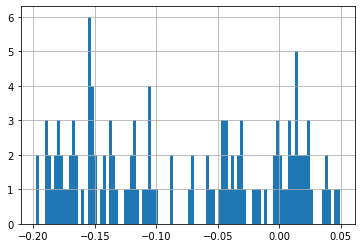

RMSE_900_day_0_mii


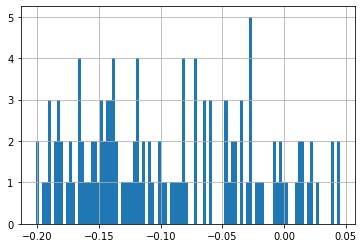

In [184]:
results_combinations = train_generated_cols(
    all_combinations(genes_calculated_columns),
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    BASE_COLS_2, REF_RESULTS,
    'l2', 'RMSE',
    10, ETA_900)

### Publication - 5 cols

In [147]:
genes_calculated_columns = [
    #'IV8-6',
    'IV8-6_normalized',
    'IV-CA',
    "IV41-8", 
    "IV16-3", 
    "IV22-2",
    ]

In [148]:
BASE_COLS_2 = [
    'test_amh_r',
    'patient_age',
    'ds1_pech_licz_10_pon',
    'prev_proc-cumulus_denuded',
    'prev_proc-day_0_mii',
    'cause_pco']

0it [00:00, ?it/s]

# Number of column combinations: 31
# ETA: 0:01:02


31it [01:03,  2.04s/it]

model: l2
sorted_by: RMSE


index         0
0  RMSE_900_cumulus_denuded -0.206887
1        RMSE_900_day_0_mii -0.178639

RMSE_900_cumulus_denuded


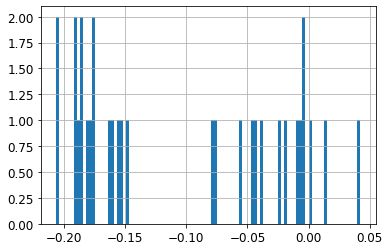

RMSE_900_day_0_mii


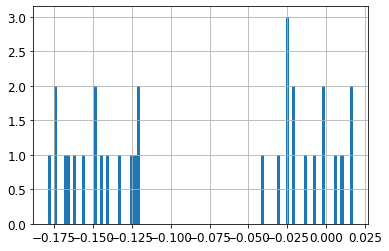

In [149]:
results_combinations = train_generated_cols(
    all_combinations(genes_calculated_columns),
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    BASE_COLS_2, REF_RESULTS,
    'l2', 'RMSE',
    10, ETA_900)

In [14]:
%load_ext blackcellmagic

In [158]:
LGB_PARAMS_BASE = {
    "metric": ["rmse", "mae", "mse", "mape"],
    "boosting": "gbdt",
    "learning_rate": 0.05,
    "verbose": -1,
    "num_leaves": 16,
    "max_depth": 64,
    "max_bin": 63,
    "seed": 42,
    "num_threads": 10,
    "num_boost_round": 500,
    "early_stopping_round": 10,
}

In [123]:
data_900_df["SOM_cols_new"] = (
    (data_900_df["ESR2_14_64227477_C_T"] == True)*1 + 
    (data_900_df["ESR1_6_152061190_A_G"] == True)*1 + 
    (data_900_df["FSHB_11_30234435_A_G"] == True)*1 + 
    (data_900_df["LHCGR_2_48729336_C_T"] == True)*1 + 
    (data_900_df["GDF9_5_132866205_T_C"] == True)*1 + 
    (data_900_df["GDF9_5_132865538_T_C"] == True)*1
)

In [134]:
data_900_df["SOM_cols_new"] = data_900_df[
    [
        "GDF9_5_132865538_T_C",
        "GDF9_5_132866205_T_C",
        "FSHB_11_30234435_A_G",
        "LHCGR_2_48729336_C_T",
        "ESR1_6_152061190_A_G",
        "ESR2_14_64227477_C_T",
    ]
].sum(axis=1)

In [138]:
data_900_df["SOM_cols"] = data_900_df[
    [
        "GDF9_5_132865538_T_C",
        "GDF9_5_132866205_T_C",
        "LHCGR_2_48729336_C_T",
        "FSHB_11_30234435_A_G",
        "ESR1_6_152061190_A_G",
        "ESR2_14_64227477_C_T",
        "AR_X_67723521_-_CACACAC", # tych powinno
        "PRL_6_22292747_A_T", # nie być
    ]
].sum(axis=1)

In [79]:
data_900_df["chr2_4GAM_block4_haplotypes_variants"] = (
    (data_900_df["genome_012_chr2_48962782_C_T"] > 0)
    & (data_900_df["genome_012_chr2_48962060_A_G"] == 0)
) * 1

In [80]:
data_900_df["chr5_4GAM_block6_haplotypes_variants"] = (
    (data_900_df["genome_012_chr5_132866719_C_G"] >0 )
    & (data_900_df["genome_012_chr5_132866082_T_A"] == 0)
    & (data_900_df["genome_012_chr5_132866205_T_C"] == 0)
) * 1

In [81]:
data_900_df['chr5_4GAM_block2_haplotypes_variants'] = (data_900_df[[
 'genome_012_chr5_35063190_A_T',
 'genome_012_chr5_35064922_C_G',
 'genome_012_chr5_35068146_G_C',
 #'genome_012_chr5_35061629_T_C',
 'genome_012_chr5_35069864_G_A',
 'genome_012_chr5_35064413_C_A',
 'genome_012_chr5_35062516_C_T',
 'genome_012_chr5_35065548_C_T'
 ]].sum(axis = 1)==0)*1

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516
-
RMSE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   4.25    (0.00)    
MAE[ test_fold_avg][l2][900_cumulus_denuded]:  count:516    avg:7.67   3.11    (0.00)    
MAPE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   0.75    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   5.52    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.35    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.48    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.68    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


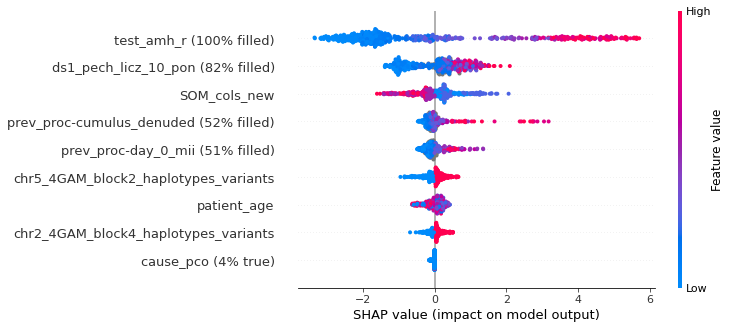

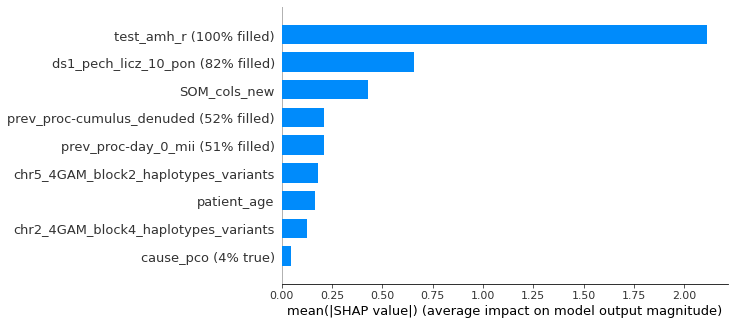

<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

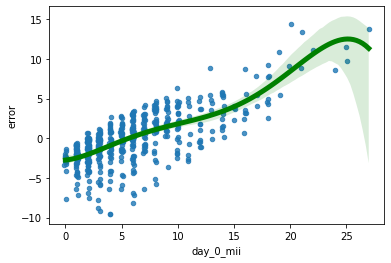

In [185]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
   "SOM_cols_new",
   "chr2_4GAM_block4_haplotypes_variants", 
   "chr5_4GAM_block2_haplotypes_variants", 
   #"chr5_4GAM_block6_haplotypes_variants"
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)

In [ ]:
LGB_PARAMS_BASE = {
    "metric": ["rmse", "mae", "mse", "mape"],
    "boosting": "gbdt",
    "learning_rate": 0.05,
    "verbose": -1,
    "num_leaves": 16,
    "max_depth": 64,
    "max_bin": 63,
    "seed": 42,
    "num_threads": 10,
    "num_boost_round": 500,
    "early_stopping_round": 10,
}

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   4.25    (0.00)    
MAE[ test_fold_avg][l2][900_cumulus_denuded]:  count:516    avg:7.67   3.12    (0.00)    
MAPE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   0.75    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   5.52    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.27    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.46    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.68    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


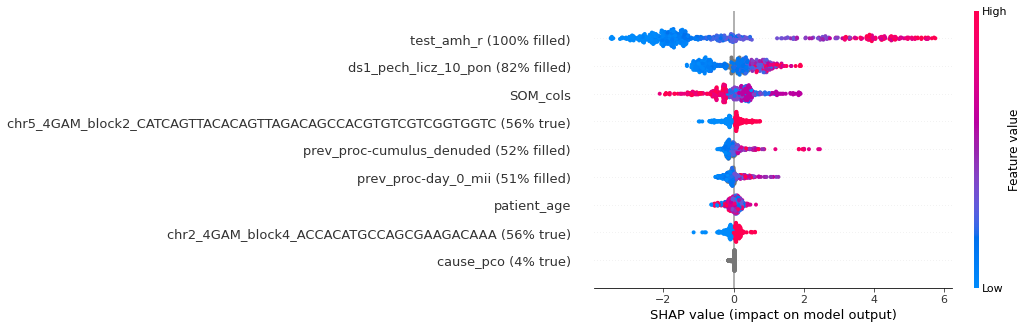

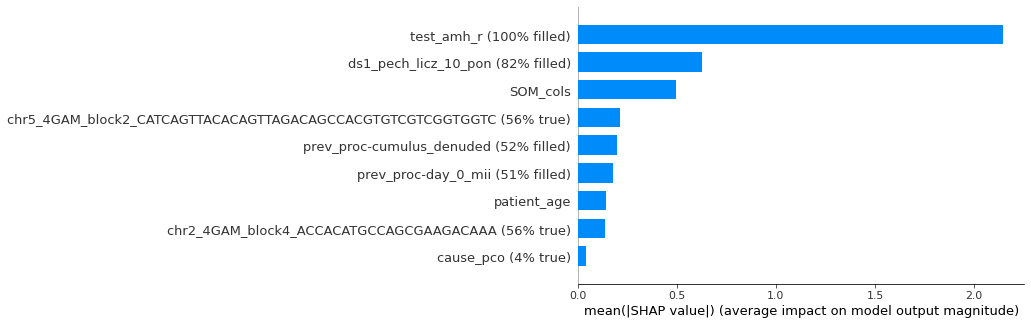

<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

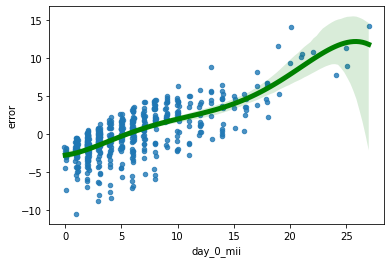

In [139]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
   "SOM_cols",
   "chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA", 
   "chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC", 
   #"chr5_4GAM_block6_haplotypes_variants"
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)

Variant: GDF9_5_132865538_T_C


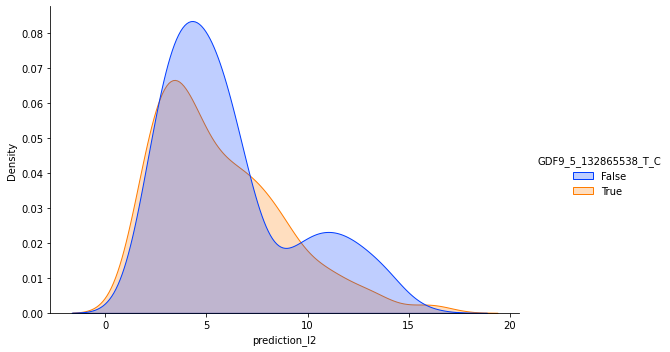

Variant: GDF9_5_132866205_T_C


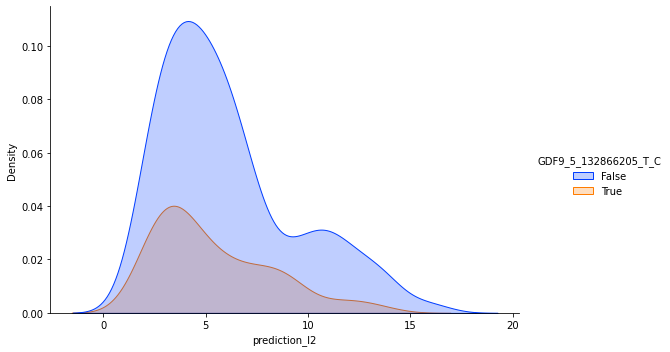

Variant: PRL_6_22292747_A_T


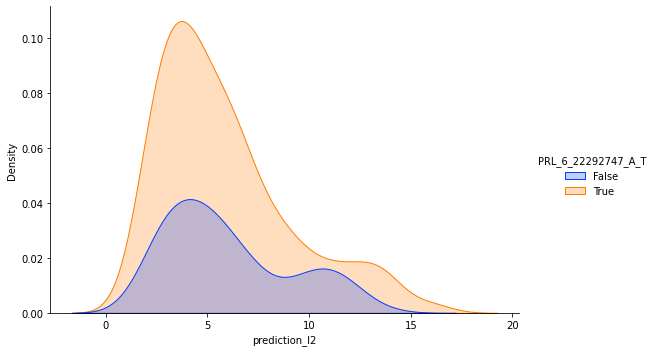

Variant: AR_X_67723521_-_CACACAC


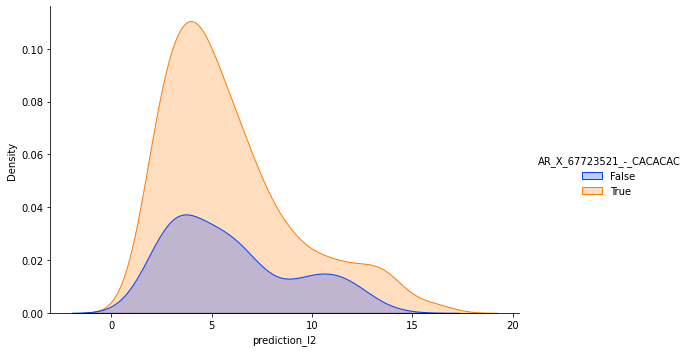

Variant: LHCGR_2_48729336_C_T


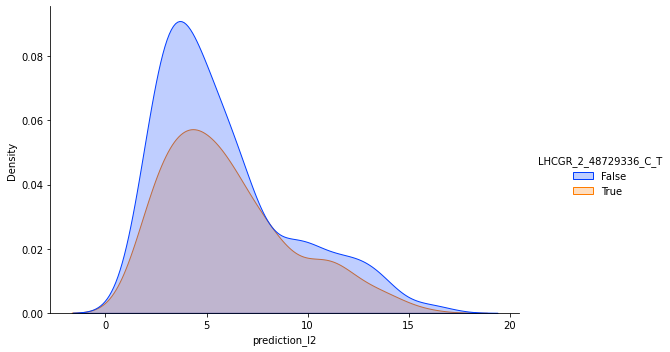

Variant: FSHB_11_30234435_A_G


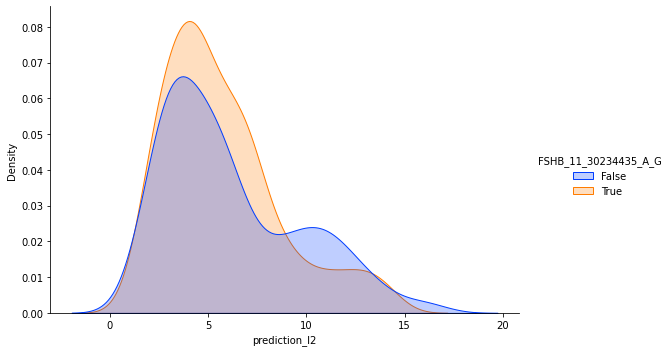

Variant: ESR1_6_152061190_A_G


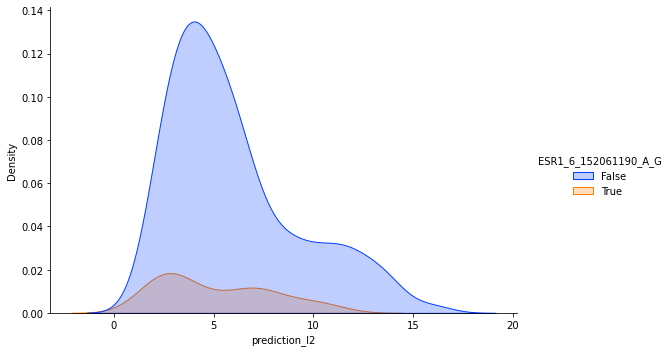

Variant: ESR2_14_64227477_C_T


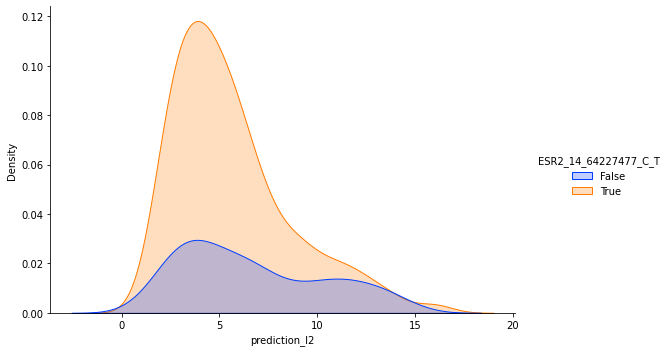

In [63]:
SOM_cols = ["GDF9_5_132865538_T_C", "GDF9_5_132866205_T_C", "PRL_6_22292747_A_T", "AR_X_67723521_-_CACACAC", "LHCGR_2_48729336_C_T", "FSHB_11_30234435_A_G", "ESR1_6_152061190_A_G", "ESR2_14_64227477_C_T"]
for variant in SOM_cols:
    print(f'Variant: {variant}')
    sns.displot(data=GENE_RESULTS_df, x='prediction_l2', hue=variant, kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
    plt.show()

In [88]:
data_900_df["SOM_cols_new"] = (
    (data_900_df["ESR2_14_64227477_C_T"] == True)*1 + 
    (data_900_df["ESR1_6_152061190_A_G"] == True)*1 + 
    (data_900_df["FSHB_11_30234435_A_G"] == True)*1 + 
    (data_900_df["LHCGR_2_48729336_C_T"] == True)*1 + 
    (data_900_df["GDF9_5_132866205_T_C"] == True)*1 + 
    (data_900_df["GDF9_5_132865538_T_C"] == True)*1 +
    (data_900_df["ESR1_6_152098960_G_A"] == True)*1
)